# **Infrared Thermography Temperature - HARRIS BARRA**

# **INTRODUCTION**

---


The goal of this is to investigate regression vs neural models on the Infrared Thermography Dataset.
                                                                                                                                         This report investigates how regressive models perform alongside a neural model which is crafted through gradual solving of overfitting via regularisation techniques and analysis of hyperparameters to fine tune to achieve an MSE of `0.0630` and `0.0347` in regression and neural respectively for aveOralF, aswell as an MSE of `0.0687` and `0.0347` in regression and neural respectively for aveOralM.

***Dataset Source:
Infrared Thermography for Measuring Elevated Body Temperature: Clinical Accuracy, Calibration, and Evaluation.  Quanzeng Wang, Yangling Zhou, Pejman Ghassemi, David McBride, J. Casamento, T. Pfefer. Sensors, 2022. https://doi.org/10.3390/s22010215***

**Download from:  https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset**

# **1) PREPROCESSING & LOADING**

---



*   Imports
*   Paths
*   Inspecting Dataset

# 1.1) Imports

---



The following code imports all the relevant libraries we need for the project.

In [64]:
import os
import pathlib
import random
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

import matplotlib.pyplot as plt

# 1.2) Paths

---



To clean up directory referencing I establish some predetermined paths where I save tuning results:


In [69]:
BASE_PATH = "C:/Users/Ayaan/Documents/Uni/MLY3T2"
MODELS_DIR = pathlib.Path(BASE_PATH + "/Models")

# 1.3) Inspecting Dataset

---



To have an understanding of what the dataset looks like, we need to first get the resource and the features(X) with labels(y).

Verify that we are properly accessing the dataset (following import code from download site):


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
infrared_thermography_temperature = fetch_ucirepo(id=925) 
  
# data (as pandas dataframes) 
X = infrared_thermography_temperature.data.features 
y = infrared_thermography_temperature.data.targets 
  
# metadata 
print(infrared_thermography_temperature.metadata) 
  
# variable information 
print(infrared_thermography_temperature.variables) 

{'uci_id': 925, 'name': 'Infrared Thermography Temperature', 'repository_url': 'https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/925/data.csv', 'abstract': 'The Infrared Thermography Temperature Dataset contains temperatures read from various locations of inferred images about patients, with the addition of oral temperatures measured for each individual. The 33 features consist of gender, age, ethnicity, ambiant temperature, humidity, distance, and other temperature readings from the thermal images. The dataset is intended to be used in a regression task to predict the oral temperature using the environment information as well as the thermal image readings. ', 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 1020, 'num_features': 33, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Gender', 'Age', 'Ethnicity'], 'target_col': ['aveO


Let's inspect the features to see count and numbers:

In [5]:
print(X)

      Gender    Age                  Ethnicity  T_atm  Humidity  Distance  \
0       Male  41-50                      White   24.0      28.0       0.8   
1     Female  31-40  Black or African-American   24.0      26.0       0.8   
2     Female  21-30                      White   24.0      26.0       0.8   
3     Female  21-30  Black or African-American   24.0      27.0       0.8   
4       Male  18-20                      White   24.0      27.0       0.8   
...      ...    ...                        ...    ...       ...       ...   
1015  Female  21-25                      Asian   25.7      50.8       0.6   
1016  Female  21-25                      White   25.7      50.8       0.6   
1017  Female  18-20  Black or African-American   28.0      24.3       0.6   
1018    Male  26-30            Hispanic/Latino   25.0      39.8       0.6   
1019  Female  18-20                      White   23.8      45.6       0.6   

      T_offset1  Max1R13_1  Max1L13_1  aveAllR13_1  ...  T_FHCC1  T_FHRC1  

The dataset shows that the dataset size is of 1020, a small dataset may benefit from cross validation techiques that we should explore. It also shows that we have 33 features, 4 of which are categorical, none (except Age) of which are ordinal; therefore they will need to be encoded before we feed it to any models.

In [7]:
print(y)

      aveOralF  aveOralM
0        36.85     36.59
1        37.00     37.19
2        37.20     37.34
3        36.85     37.09
4        36.80     37.04
...        ...       ...
1015     36.95     36.99
1016     37.25     37.19
1017     37.35     37.59
1018     37.15     37.29
1019     37.05     37.19

[1020 rows x 2 columns]


The labelset is divided into 2 targets, both represent the same label but obtained through different methods. Both are continuous, classification problems require these to be be binary or categorical, however for regression tasks the existing values are suitable.

Additionally no missing data is mentioned or seen in the dataset, therefore imputation methods will not be explored.

# **2) CATEGORICAL ENCODING & DATA ANALYSIS**

---



*   Encoding
*   Feature Importance
*   Feature Correlations

# 2.1) Encoding

---



Previously mentioned we need to encode the categorical data such that it is ready to be used.

In [4]:
# Combine targets to data to get the full dataset
fullDataset = X.copy()
fullDataset["aveOralF"] = y["aveOralF"]
fullDataset["aveOralM"] = y["aveOralM"]

# Ensure that we have dropped any rows that contain NaN
cleanedDataset = fullDataset.dropna()

# Split the dataset back to X and y
X = cleanedDataset.drop(columns=["aveOralF", "aveOralM"])
y = cleanedDataset[["aveOralF", "aveOralM"]]

In [5]:
# Drop the 'subjectID' column as ID it's not relevant
df = X.drop(columns=["subjectID"], errors="ignore")

# One-hot encode categorical variables into binary features
dfEncoded = pd.get_dummies(df, drop_first=True)

print(dfEncoded.head())

   T_atm  Humidity  Distance  T_offset1  Max1R13_1  Max1L13_1  aveAllR13_1  \
0   24.0      28.0       0.8     0.7025    35.0300    35.3775      34.4000   
1   24.0      26.0       0.8     0.7800    34.5500    34.5200      33.9300   
2   24.0      26.0       0.8     0.8625    35.6525    35.5175      34.2775   
3   24.0      27.0       0.8     0.9300    35.2225    35.6125      34.3850   
4   24.0      27.0       0.8     0.8950    35.5450    35.6650      34.9100   

   aveAllL13_1    T_RC1  T_RC_Dry1  ...  Age_26-30  Age_31-40  Age_41-50  \
0      34.9175  34.9850    34.9850  ...      False      False       True   
1      34.2250  34.7100    34.6325  ...      False       True      False   
2      34.8000  35.6850    35.6675  ...      False      False      False   
3      35.2475  35.2075    35.2000  ...      False      False      False   
4      35.3675  35.6025    35.4750  ...      False      False      False   

   Age_51-60  Age_>60  Ethnicity_Asian  Ethnicity_Black or African-America

Dimensionality has increased by 10 more features, we can expect to see that some of these features are not important to prediction and can potentially lead to worsening overfitting which we will investigate and resolve.

# 2.2) Feature Importance

---



We can run a random forest regression on both target labels to see what features are most important.

In [188]:
def featureImportanceRegression(X, name):
    # Scale data
    scaler = StandardScaler()
    XScaled = scaler.fit_transform(X) 
    # Fit the model
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(XScaled, y[name])
    
    # Create a dataframe with feature importances
    featureImportances = pd.DataFrame({
        "Feature": features,
        "Importance": feature_importance
    })
    
    # Sort the dataframe in descending order
    sortedFeatureImportances = featureImportances.sort_values(by="Importance", ascending=False)
    
    # Plot feature importancs
    plt.figure(figsize=(12, 10))
    plt.barh(sortedFeatureImportances["Feature"], sortedFeatureImportances["Importance"], color="purple")
    plt.xlabel("Score")
    plt.ylabel("Features")
    plt.title(f"Feature Importances ({name})")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

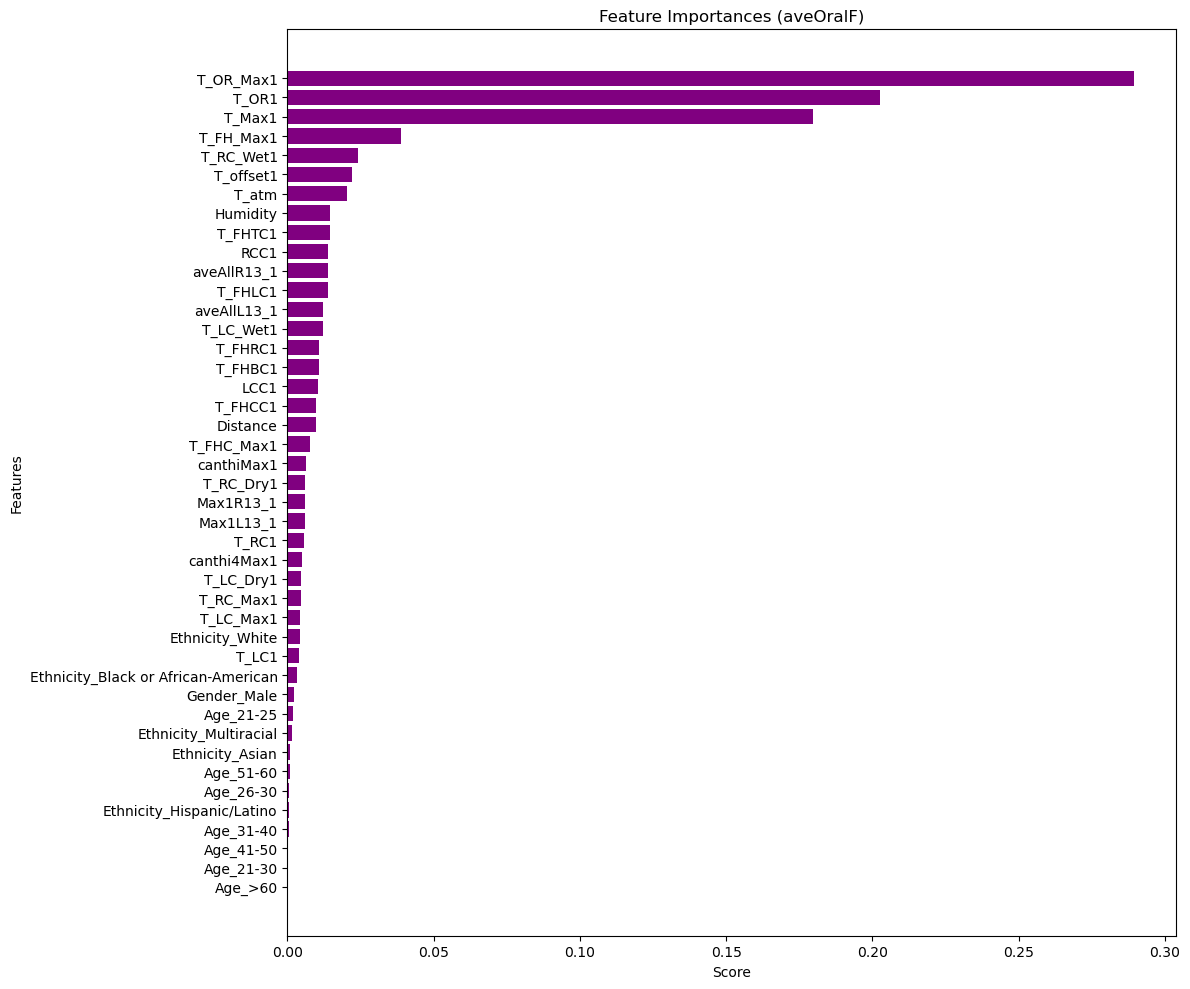

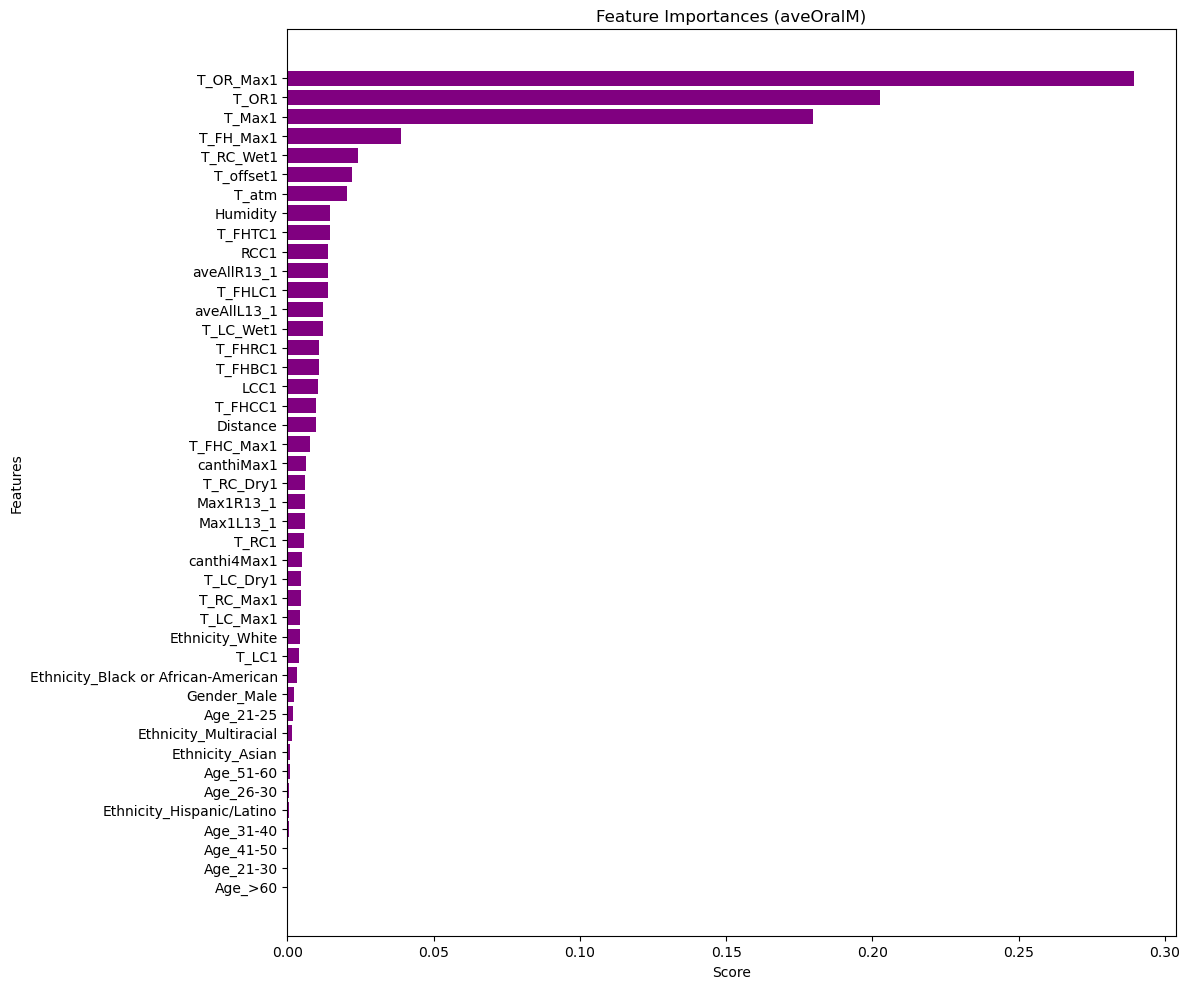

In [189]:
featureImportanceRegression(dfEncoded, "aveOralF")
featureImportanceRegression(dfEncoded, "aveOralM")

Majority of continuous values have good importance scores, however the lowest scoring features are the categorical ones, this doesn't speak to the feature itself but rather the specific value from that scores. We can expect to see that Ethnicity and Age is not an important enough factor in prediction and regularisation will most likely be needed to penalise these lower values.

# 2.3) Feature Correlations

---



Correlations can be useful for finding any linear relationships between data and targets.

In [61]:
def correlationGraph(name):
    correlation = dfEncoded.corrwith(y[name])
    
    # Print the correlation of features
    print(correlation)
    
    correlation.sort_values(ascending=False).plot(kind="bar", figsize=(10, 6))
    plt.title(f"Correlation of Features with Target ({name})")
    plt.xlabel("Features")
    plt.ylabel("Correlation")
    plt.show()

T_atm                                  0.071029
Humidity                               0.048302
Distance                               0.016166
T_offset1                              0.118423
Max1R13_1                              0.637499
Max1L13_1                              0.621755
aveAllR13_1                            0.535454
aveAllL13_1                            0.543933
T_RC1                                  0.664535
T_RC_Dry1                              0.643972
T_RC_Wet1                              0.654397
T_RC_Max1                              0.665237
T_LC1                                  0.633391
T_LC_Dry1                              0.627750
T_LC_Wet1                              0.611324
T_LC_Max1                              0.633548
RCC1                                   0.611905
LCC1                                   0.586746
canthiMax1                             0.673656
canthi4Max1                            0.673035
T_FHCC1                                0

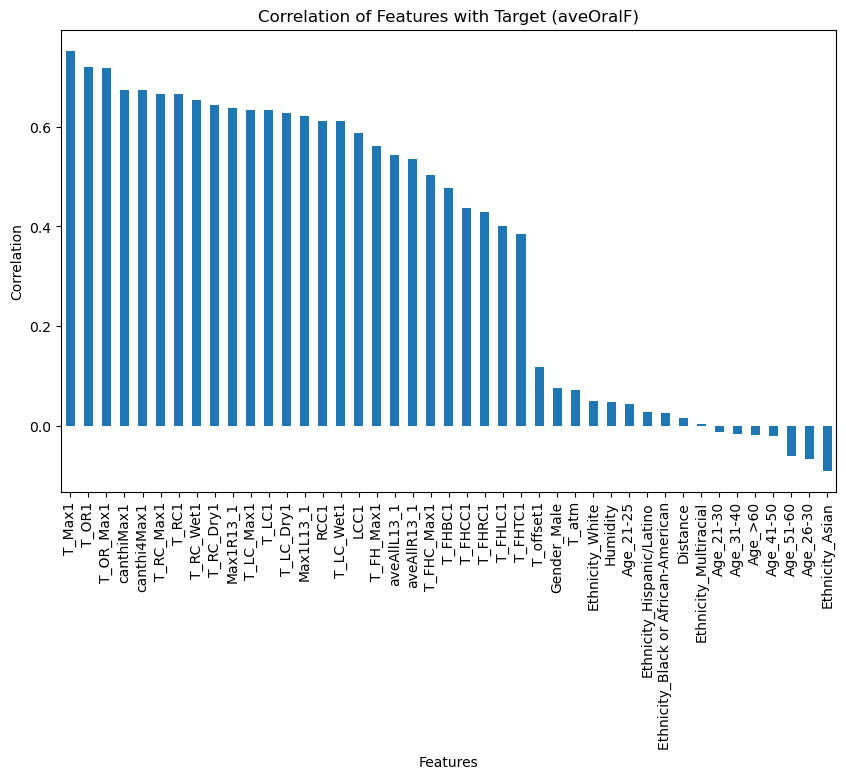

T_atm                                  0.098785
Humidity                               0.064137
Distance                               0.011181
T_offset1                              0.139412
Max1R13_1                              0.742377
Max1L13_1                              0.735877
aveAllR13_1                            0.622122
aveAllL13_1                            0.648076
T_RC1                                  0.769145
T_RC_Dry1                              0.749038
T_RC_Wet1                              0.760433
T_RC_Max1                              0.769876
T_LC1                                  0.750653
T_LC_Dry1                              0.743938
T_LC_Wet1                              0.720585
T_LC_Max1                              0.750764
RCC1                                   0.714478
LCC1                                   0.696868
canthiMax1                             0.784564
canthi4Max1                            0.784227
T_FHCC1                                0

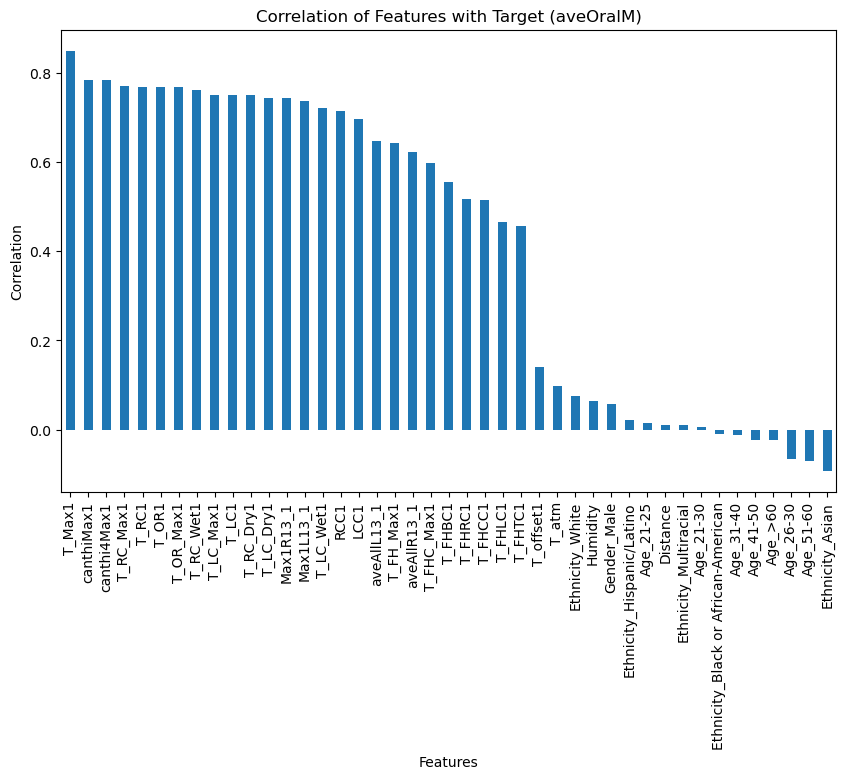

In [62]:
correlationGraph("aveOralF")
correlationGraph("aveOralM")

Correlation reflects and compliments our feature importance findings. Facial temperature is the most important indicator of feverish behaviour, the correlation is amplified when using the Monitor-mode target. There is also a threshold distinction at about 0.4 where features can be split into either strong correlation or quite weak correlation.

In [54]:
def scatterCorrelationGraph(name):
    # Get the correlation of features with the target
    correlation = dfEncoded.corrwith(y[name])
    
    # Select features that have a non-nominal signficance, correlation suggests approx 0.35-0.40 is a good threshold
    significantFeatures = correlation[correlation.abs() > 0.35].index
    
    # Create scatter plots for each of the significant features to visualise the strong correlations
    for feature in significantFeatures:
        plt.figure(figsize=(13, 3))
        plt.scatter(dfEncoded[feature], y[name], alpha=0.5)
        plt.title(f"Scatter Plot of {feature} vs {name}")
        plt.xlabel(f"{feature}")
        plt.ylabel(f"{name}")
        plt.show()

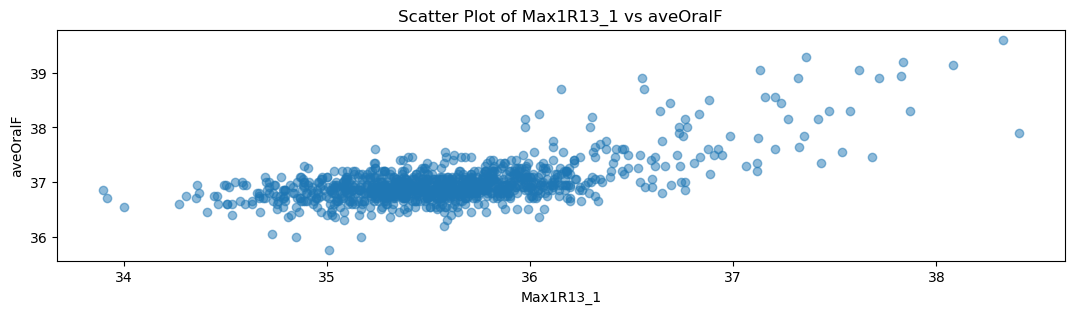

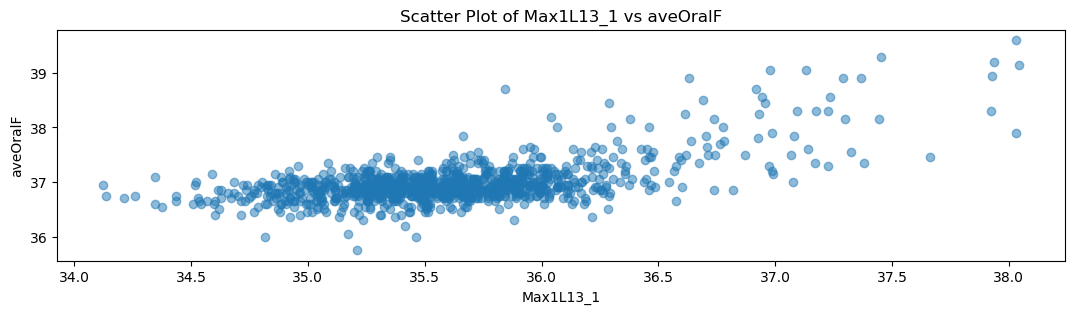

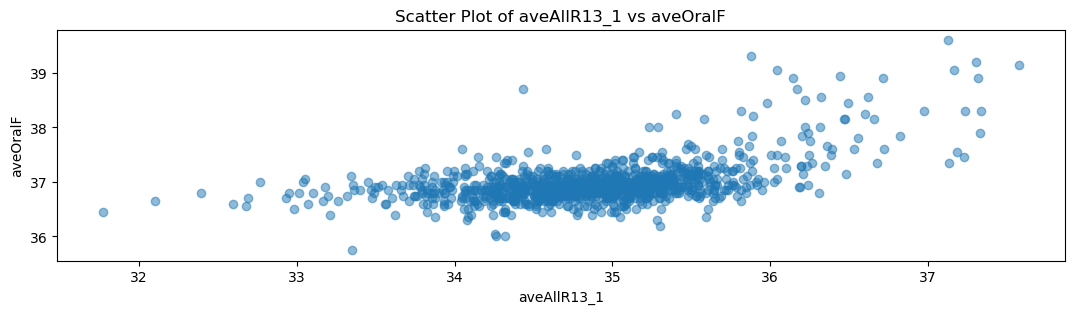

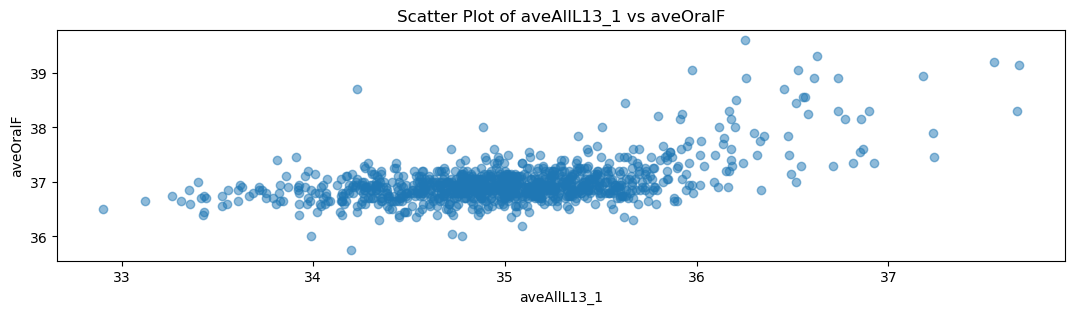

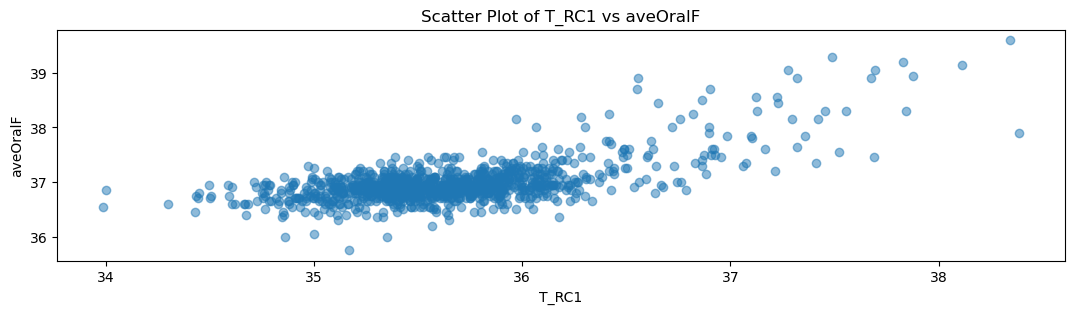

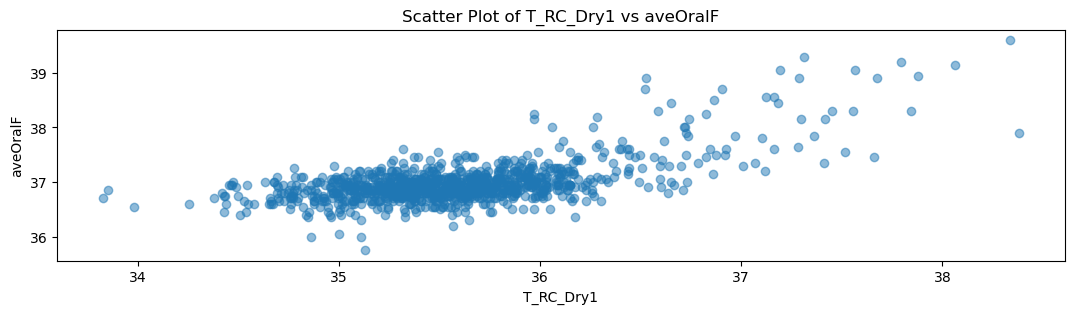

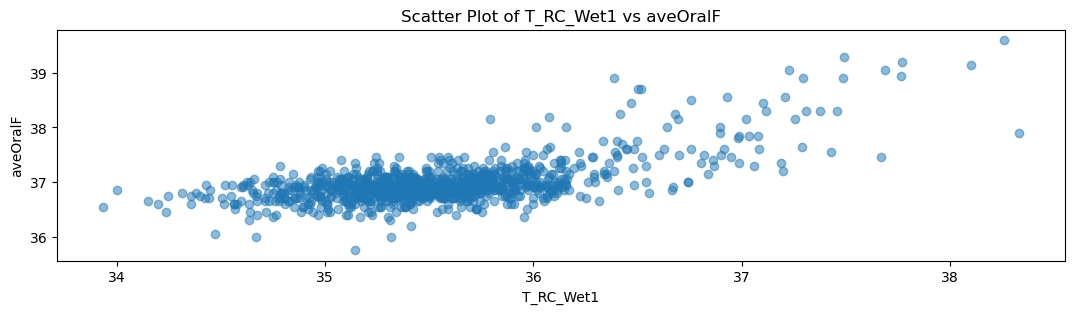

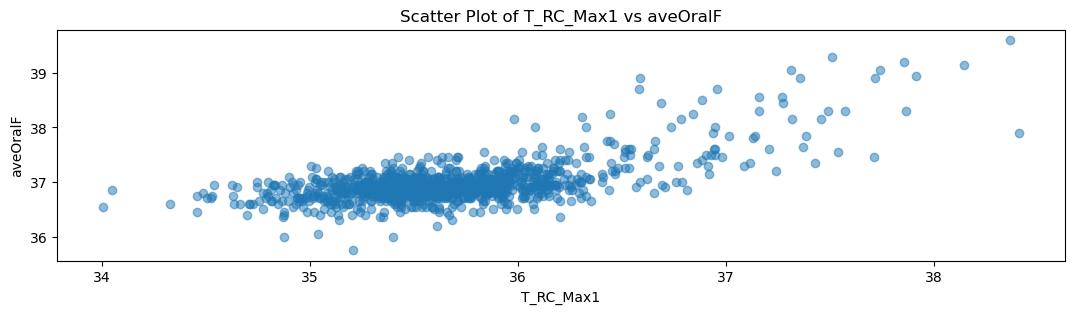

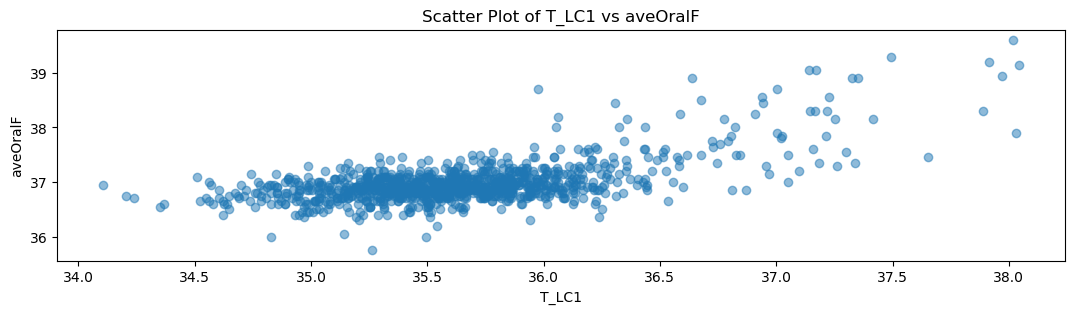

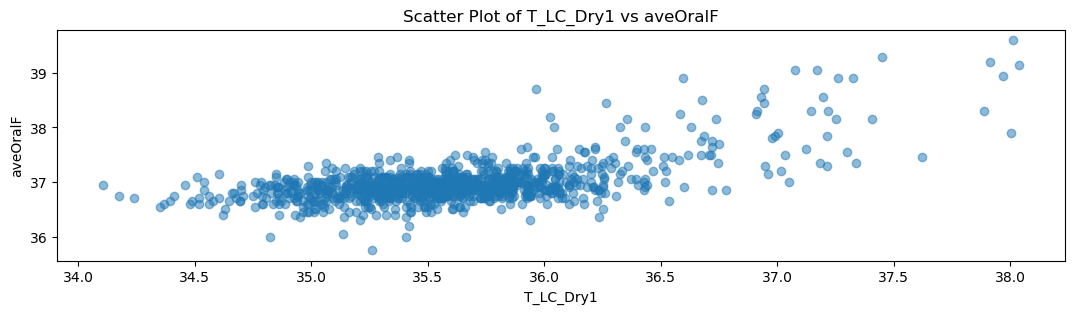

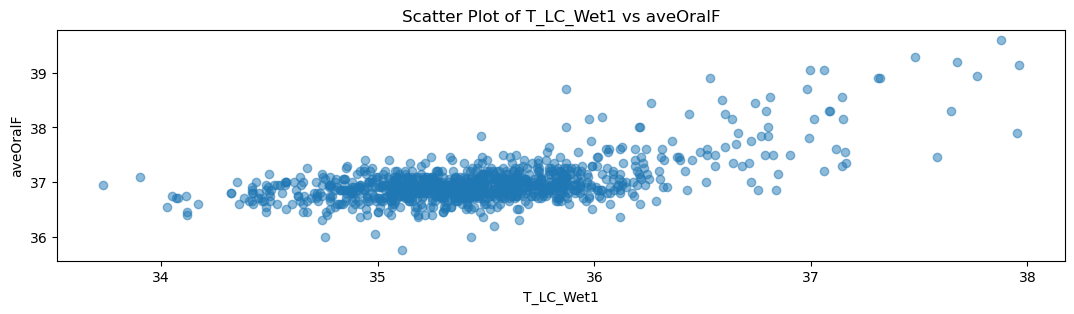

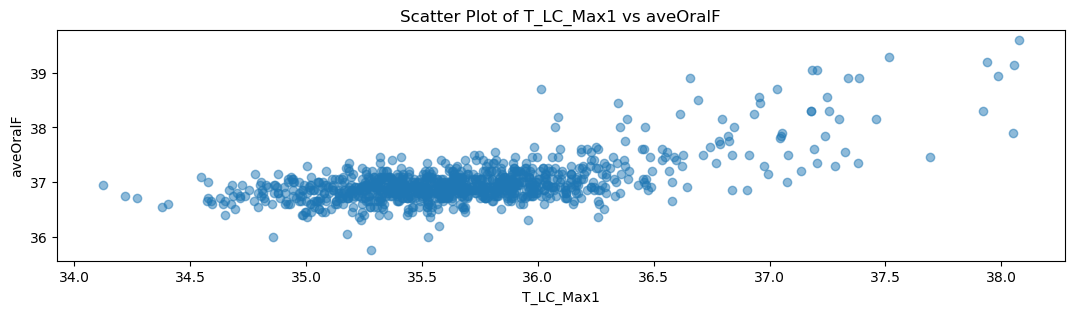

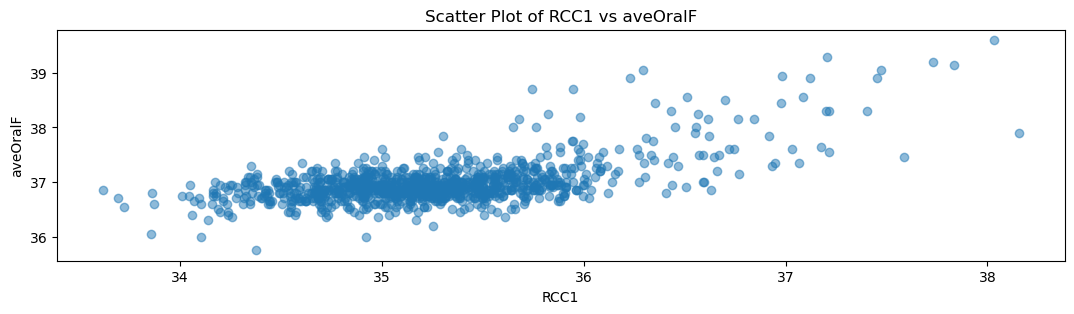

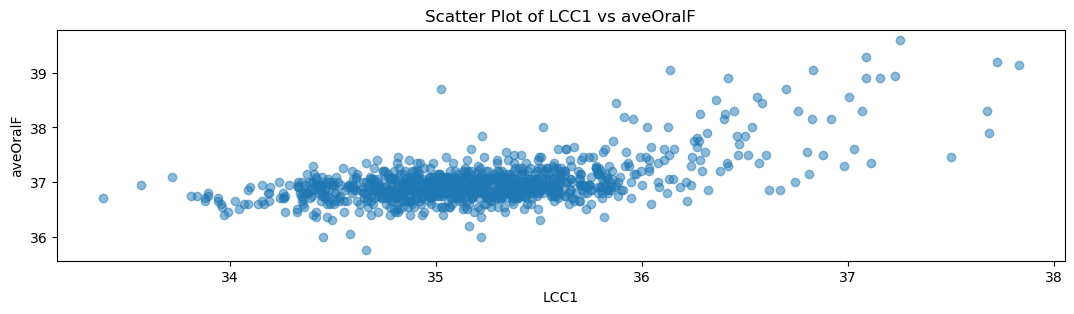

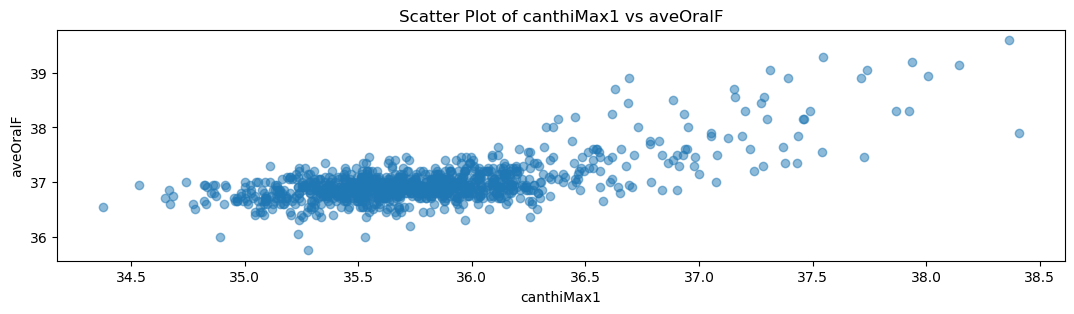

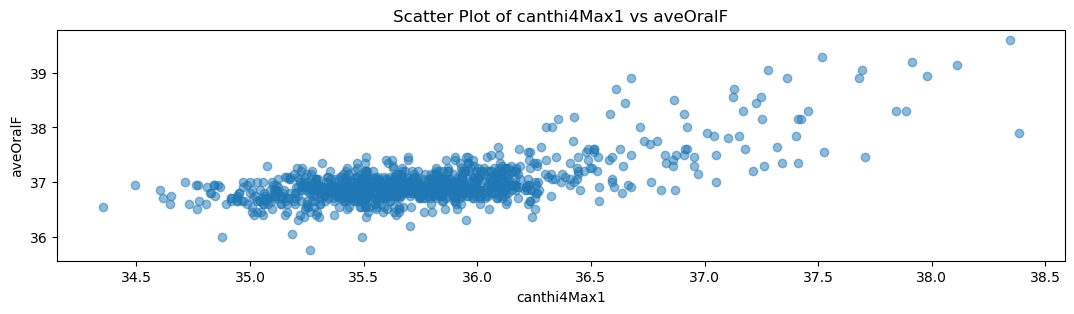

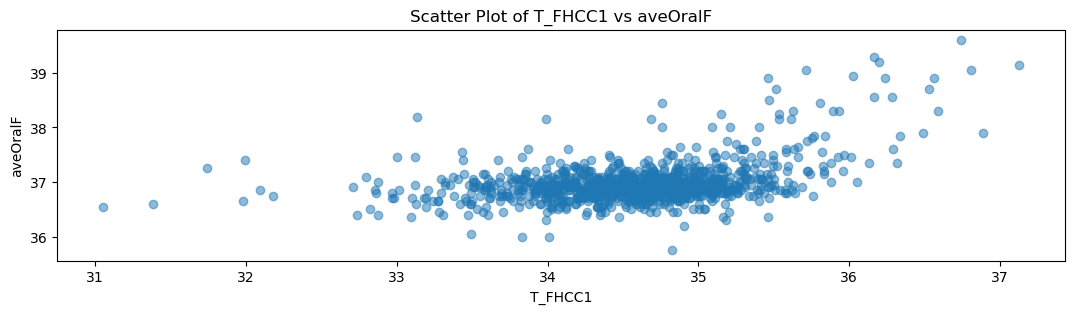

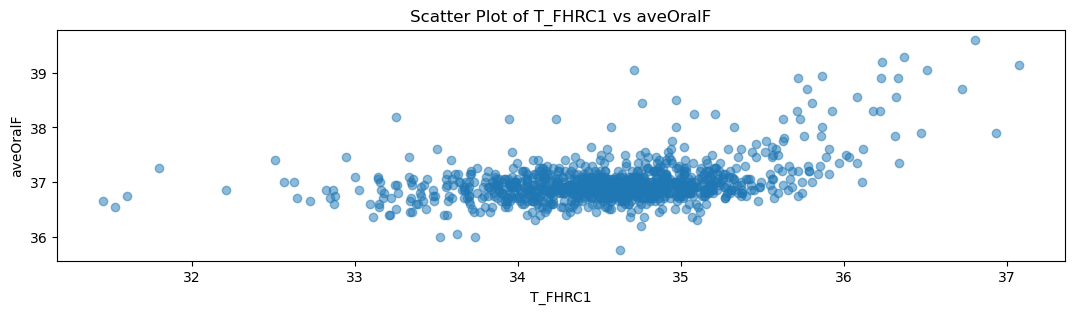

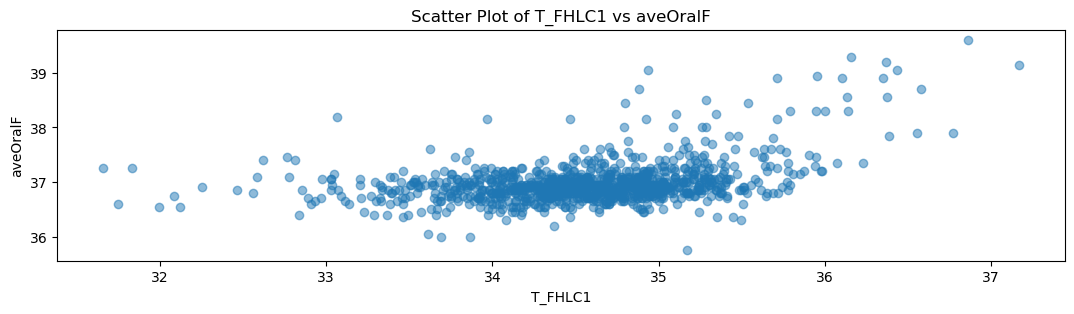

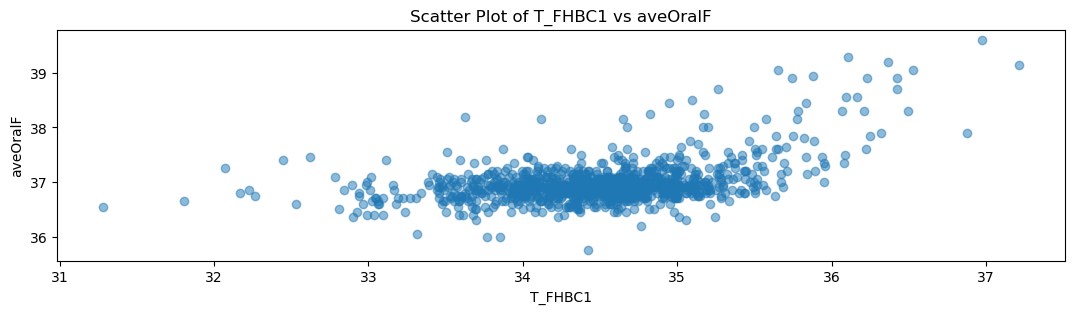

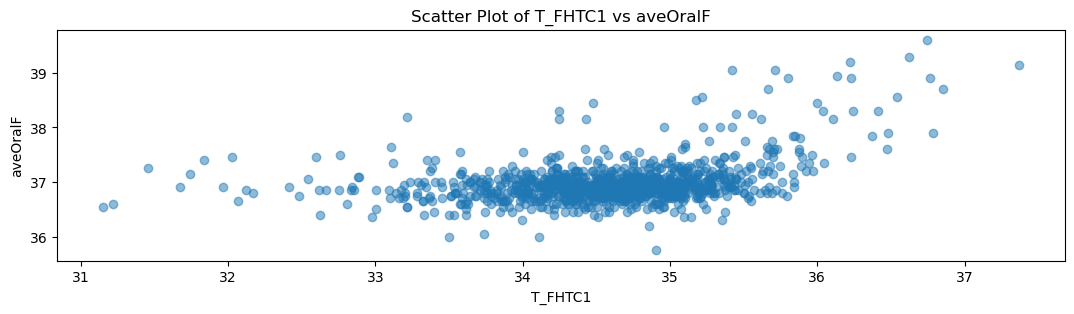

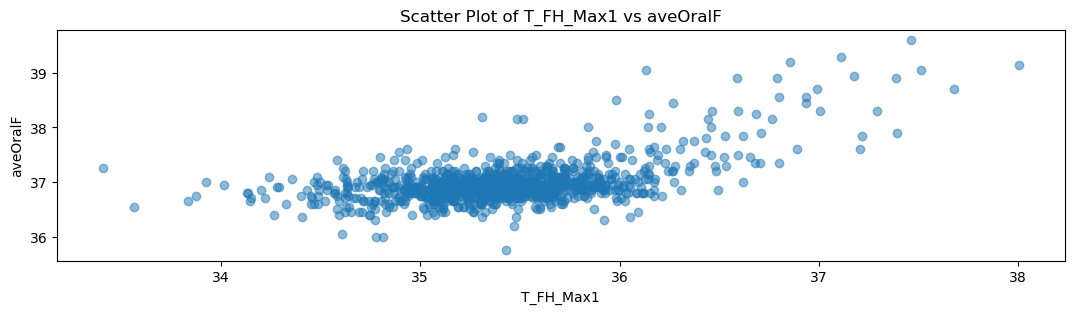

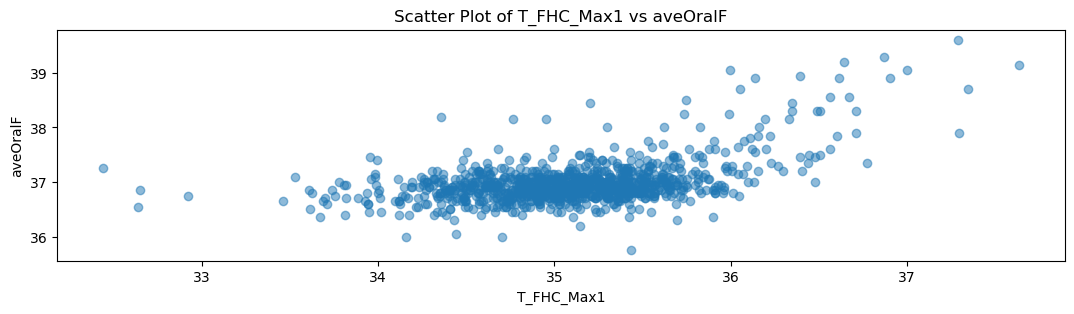

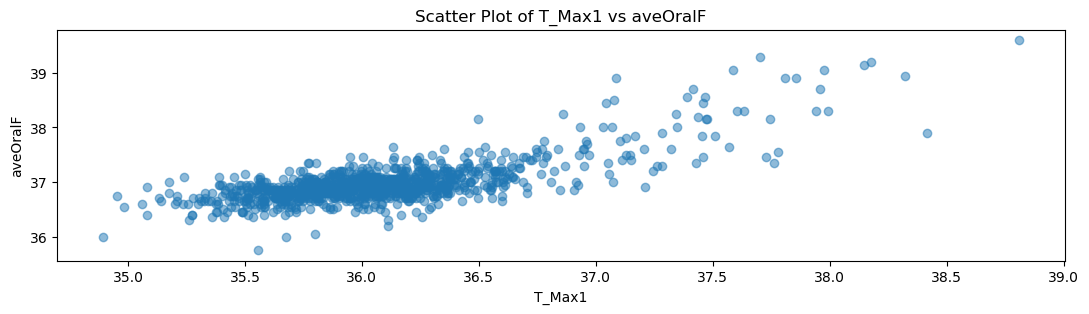

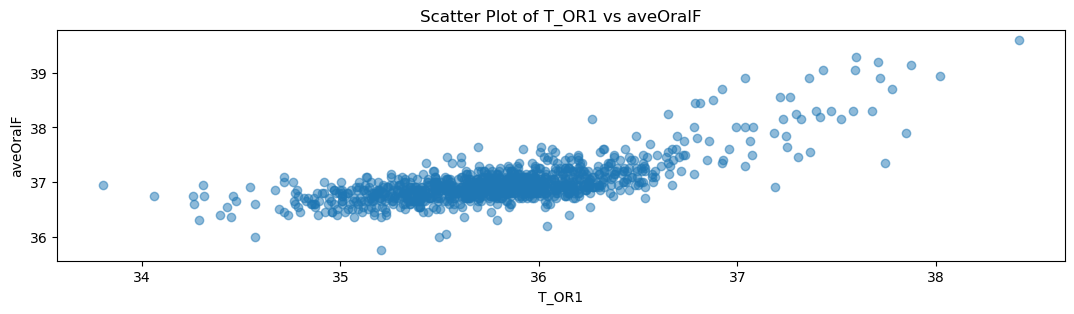

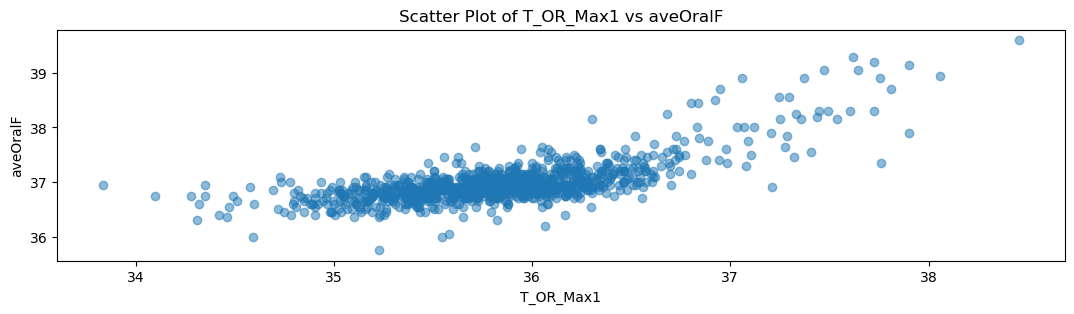

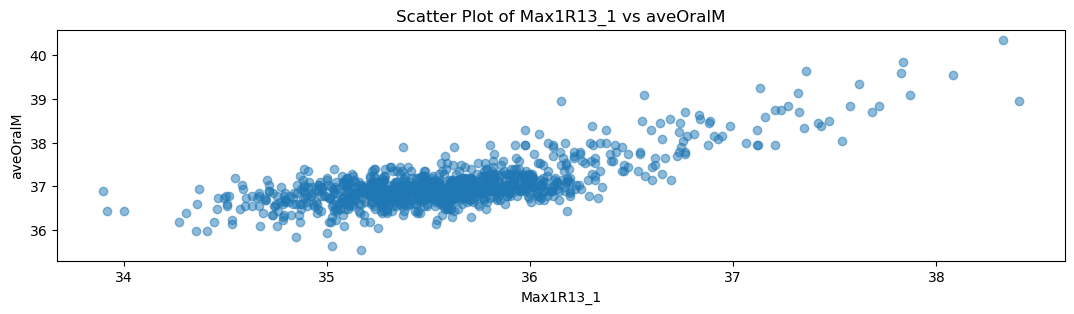

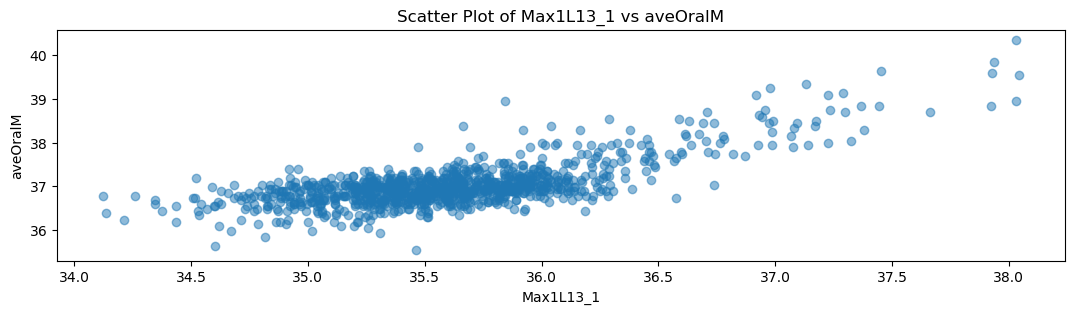

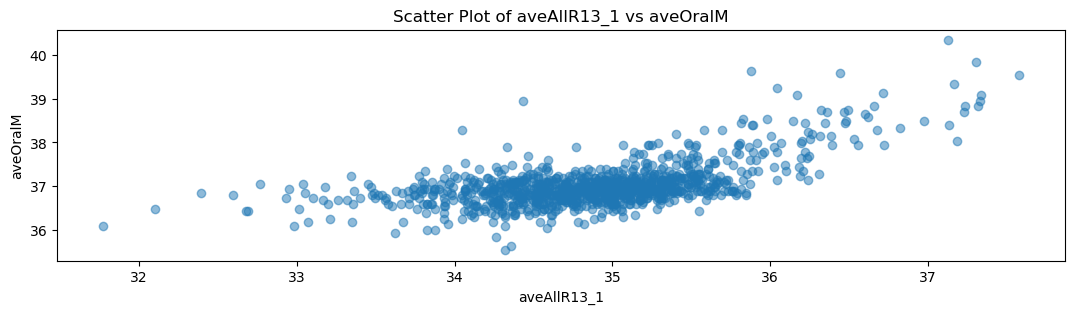

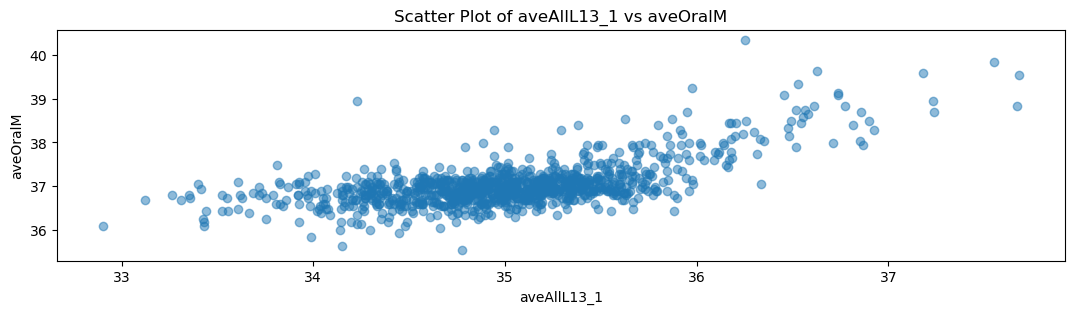

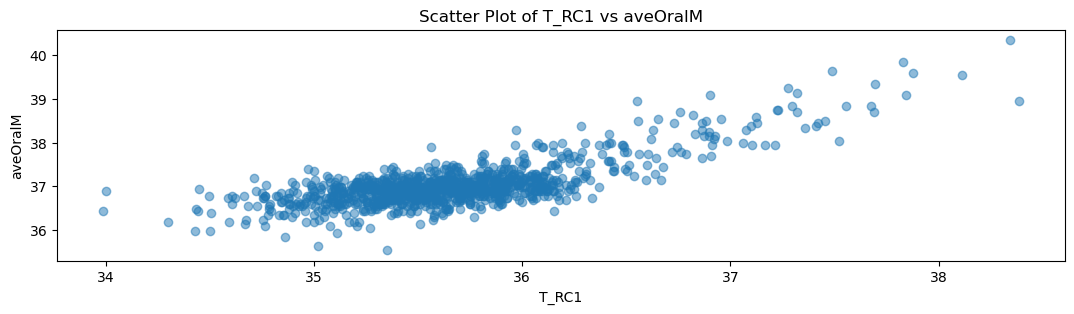

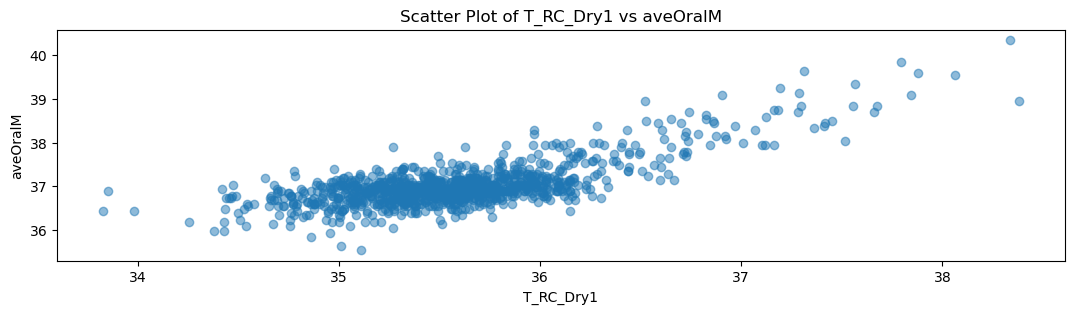

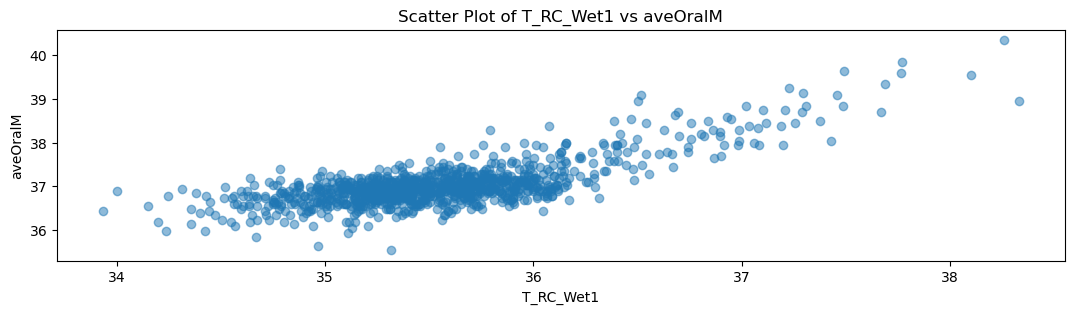

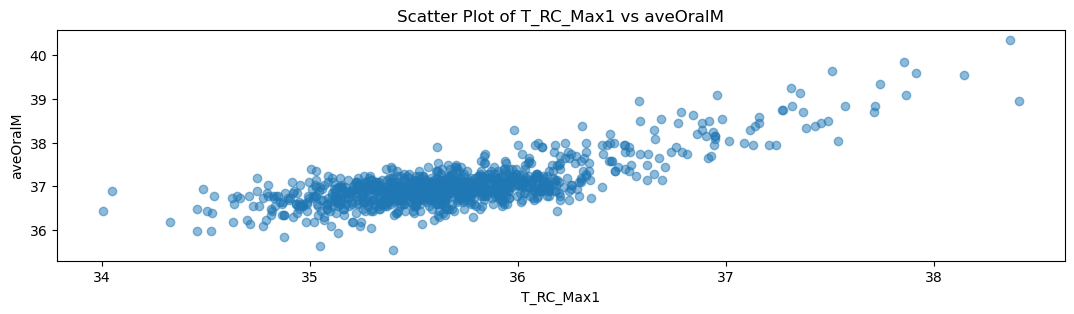

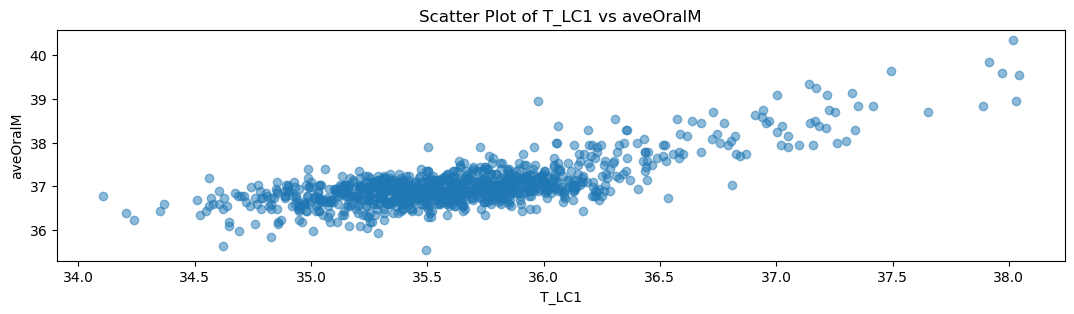

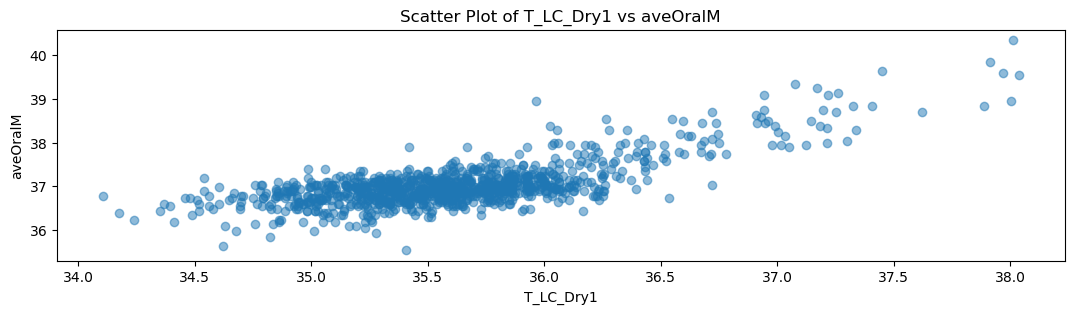

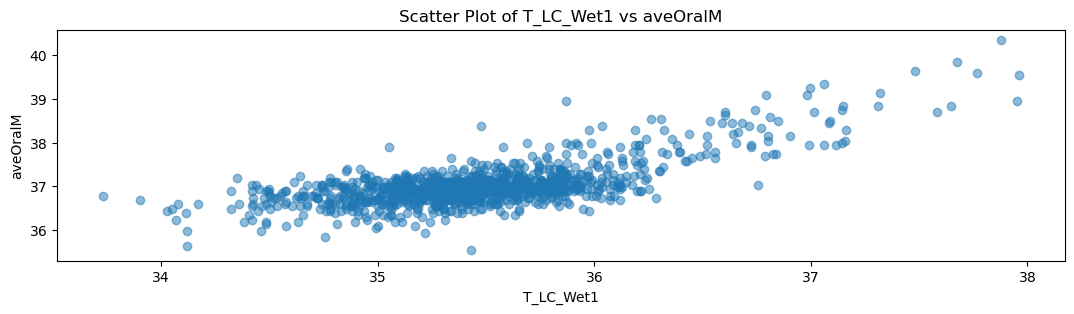

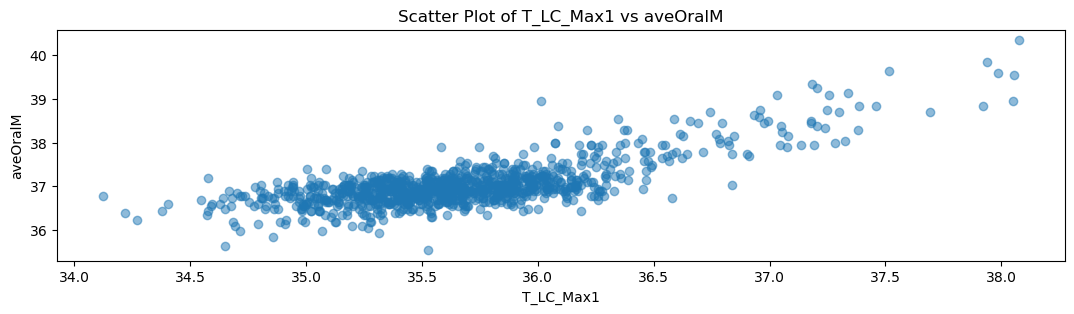

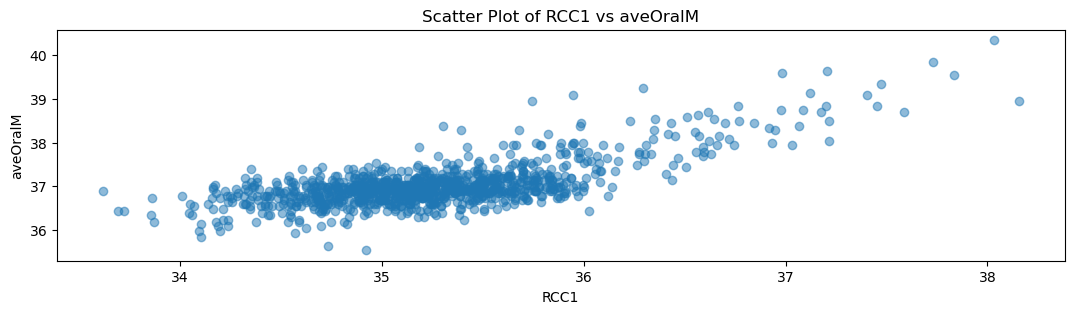

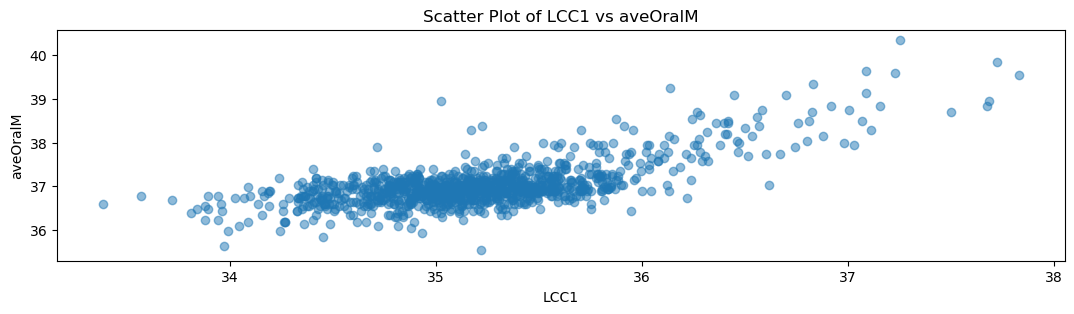

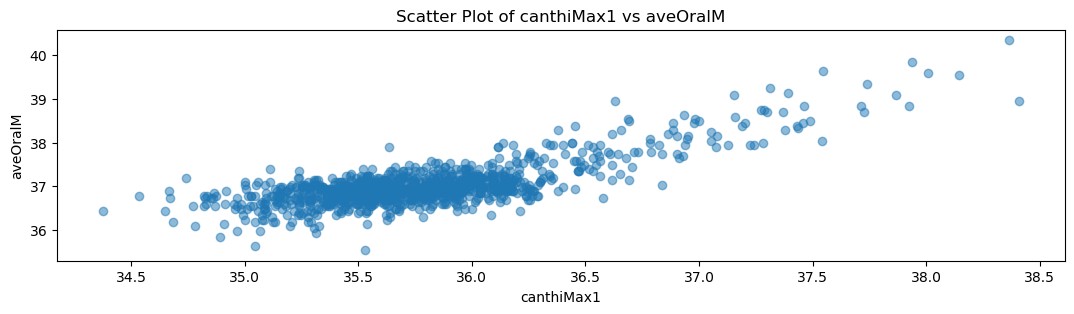

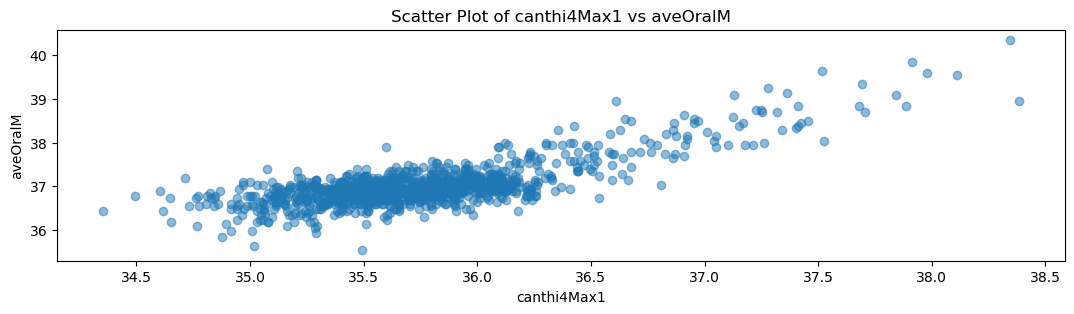

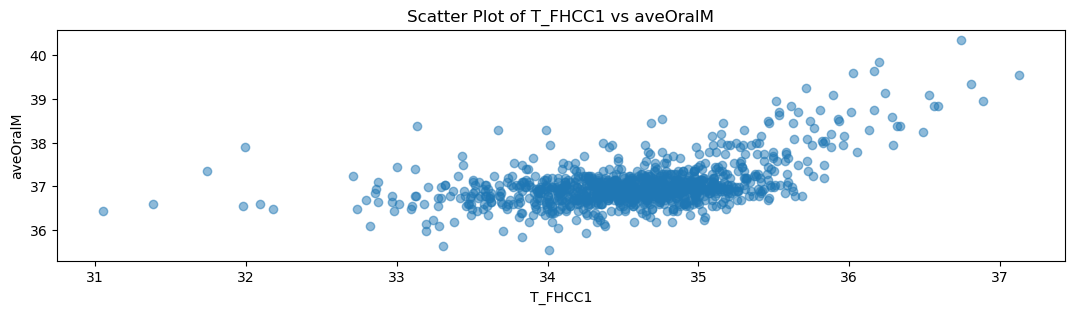

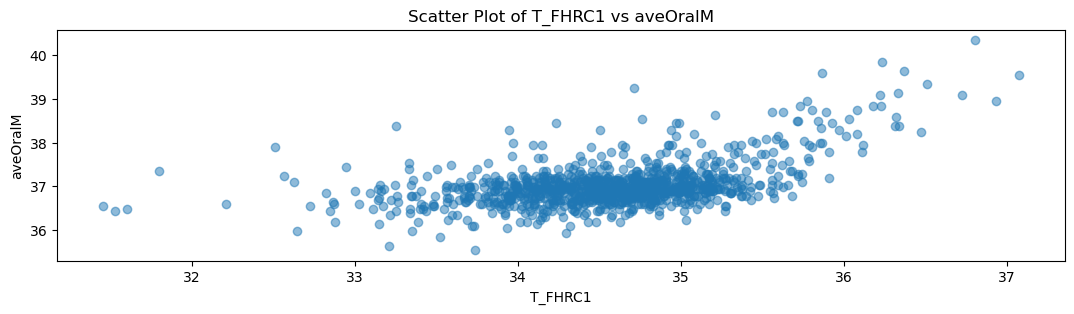

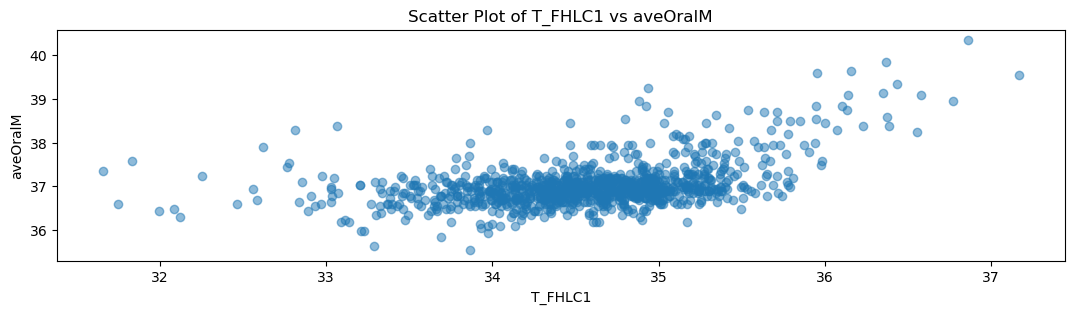

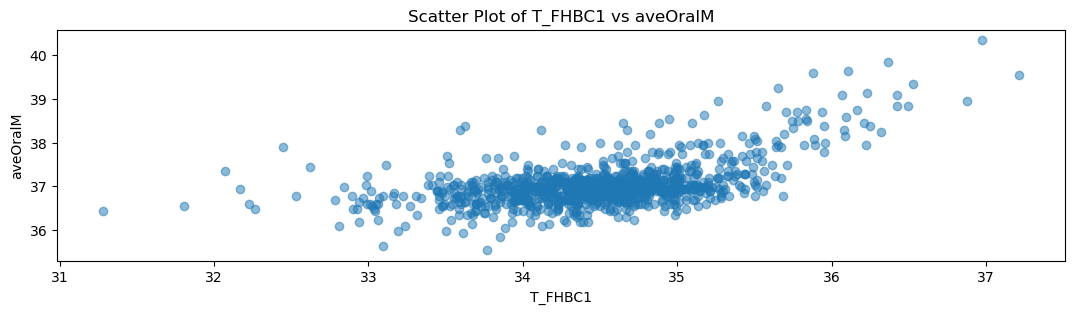

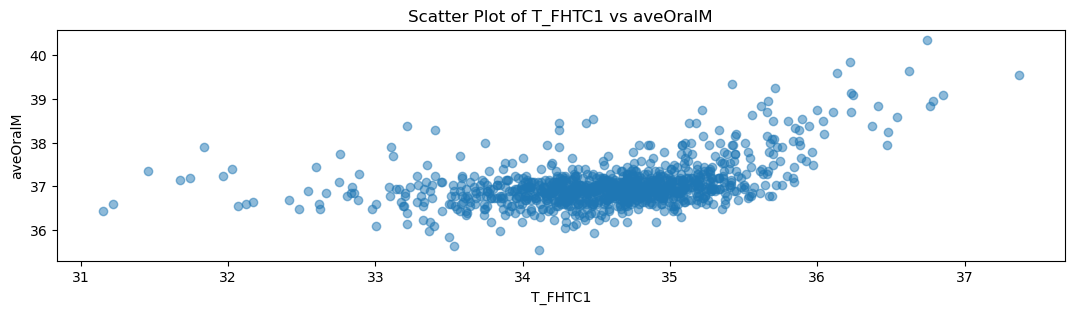

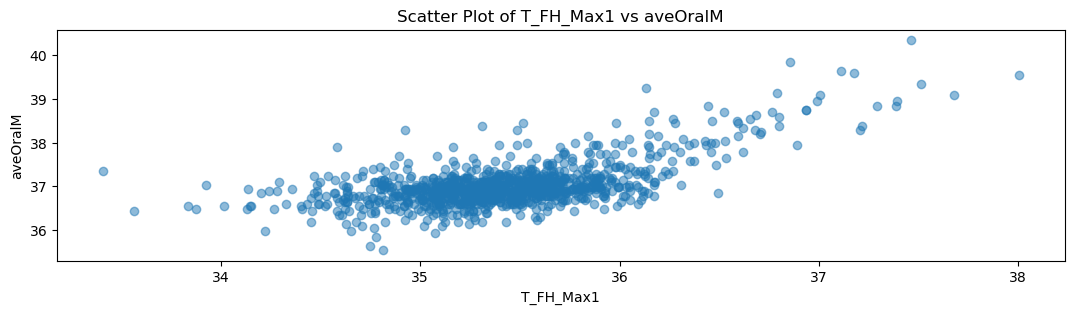

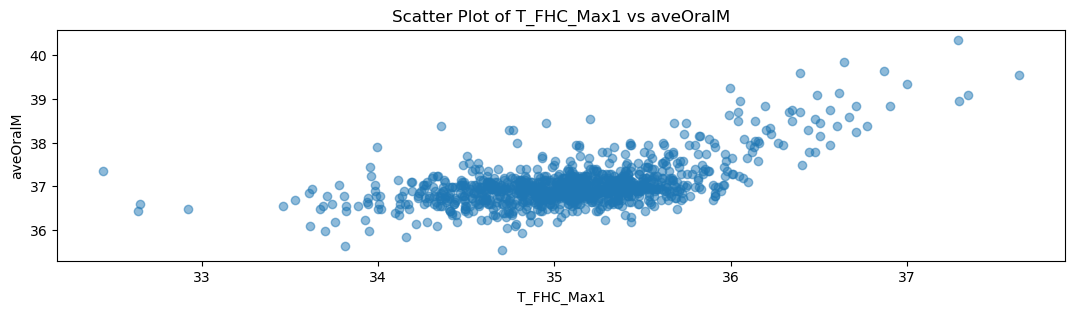

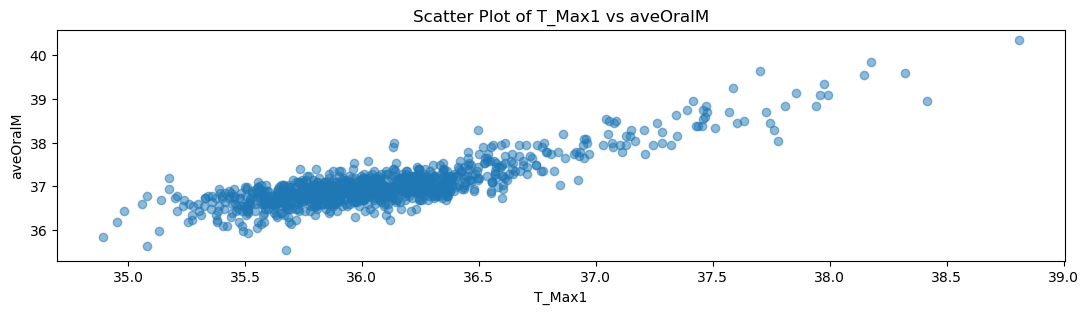

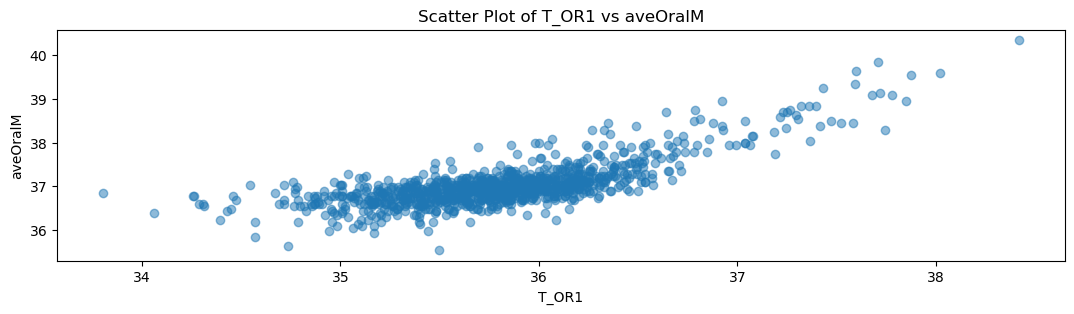

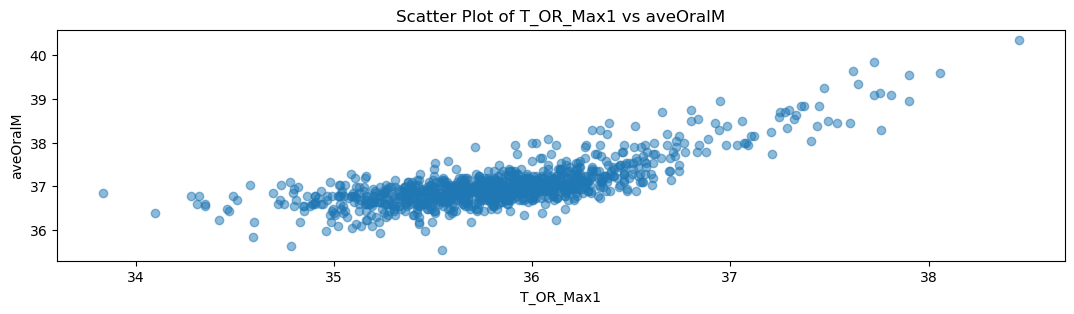

In [93]:
scatterCorrelationGraph("aveOralF")
scatterCorrelationGraph("aveOralM")

Some algorithms that we will explore will not be able to filter out some of the weaker features thus leading to worsening metrics, so using our threshold we can get a list of the weak features.

In [6]:
correlation = dfEncoded.corrwith(y["aveOralM"])
lowCorrFeatures = correlation[correlation.abs() < 0.35].index.tolist()
print(lowCorrFeatures)

['T_atm', 'Humidity', 'Distance', 'T_offset1', 'Gender_Male', 'Age_21-25', 'Age_21-30', 'Age_26-30', 'Age_31-40', 'Age_41-50', 'Age_51-60', 'Age_>60', 'Ethnicity_Asian', 'Ethnicity_Black or African-American', 'Ethnicity_Hispanic/Latino', 'Ethnicity_Multiracial', 'Ethnicity_White']


# **3) REGRESSION MODELS**

---



*   Extra Metric Functions
*   Linear Regression Baseline
*   Polynomial Regression
*   ElasticNet
*   KNN
*   Fine-Tuning Best Regression Models

# 3.1) Extra Metric Functions

---



To measure any hold-out performances, we can utilise a few different functions.

In [7]:
def printRegressionMetrics(truth, prediction, name):
    # MSE (Mean Squared Error)
    mse = mean_squared_error(truth, prediction)
    print(f"{name} - Mean Squared Error (MSE): {mse}")
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)
    print(f"{name} - Root Mean Squared Error (RMSE): {rmse}")
    
    # R2 (R squared)
    r2 = r2_score(truth, prediction)
    print(f"{name} - R-squared: {r2}")
    
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(truth, prediction)
    print(f"{name} - Mean Absolute Error (MAE): {mae}")

In [8]:
def getRegressionMetrics(truth, prediction):
    # MSE (Mean Squared Error)
    mse = mean_squared_error(truth, prediction)
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)
    # R2 (R squared)
    r2 = r2_score(truth, prediction)
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(truth, prediction)

    return mse, rmse, r2, mae

# 3.2) Linear Regression Baseline

---



To establish a baseline, we will use Linear Regression to get an idea of metrics to compare and beat with more advanced regression models.

In [187]:
# Use a 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(dfEncoded, y["aveOralF"], test_size=0.2, shuffle=True, random_state=42)

# Use standard scaler
scaler = StandardScaler()
# Fit to the train and then scale to test to prevent leakage
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

# Fit to the model
model = LinearRegression()
model.fit(xTrain, yTrain)

# Predict
prediction = model.predict(xTest)
printRegressionMetrics(yTest, prediction, "aveOralF")

print("-----------------------------------")

# Repeat for the other target
xTrain, xTest, yTrain, yTest = train_test_split(dfEncoded, y["aveOralM"], test_size=0.2, shuffle=True, random_state=42)
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)
model = LinearRegression()
model.fit(xTrain, yTrain)
prediction = model.predict(xTest)
printRegressionMetrics(yTest, prediction, "aveOralM")

aveOralF - Mean Squared Error (MSE): 0.054356806292093114
aveOralF - Root Mean Squared Error (RMSE): 0.233145461658796
aveOralF - R-squared: 0.49704001008276666
aveOralF - Mean Absolute Error (MAE): 0.1801354938871838
-----------------------------------
aveOralM - Mean Squared Error (MSE): 0.06670903790326183
aveOralM - Root Mean Squared Error (RMSE): 0.2582809282608025
aveOralM - R-squared: 0.6646465319796597
aveOralM - Mean Absolute Error (MAE): 0.20323260671028354


In [176]:
# Use standard scaler
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralF"]

# Fit to the model
linearModel = LinearRegression()

# Cross validation scores
mseScores = cross_val_score(linearModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(linearModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)

print(f"aveOralF - Mean Squared Error (MSE): {mse}")
print(f"aveOralF - R-squared: {r2}")
print("-----------------------------------")

# Repeat for other target
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralM"]
linearModel = LinearRegression()
mseScores = cross_val_score(linearModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(linearModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)
print(f"aveOralM - Mean Squared Error (MSE): {mse}")
print(f"aveOralM - R-squared: {r2}")

aveOralF - Mean Squared Error (MSE): 0.30063430875990127
aveOralF - R-squared: -1.0939359938719115
-----------------------------------
aveOralM - Mean Squared Error (MSE): 0.5425184850673945
aveOralM - R-squared: -0.8857045329000297


Linear presents fair results on a hold-out setup, however R-squared shows the worst numbers specifically when doing cross-validation. In this context R2 hints at us that the model of choice is not the best fit for the targets. Using hold-out can be problematic, we could be giving an unfair shuffle or split that favours a specific range of data, ideally hold-out is best suited for larger datasets, since we are dealing with a smaller dataset, to prevent any skewed or biased results we will measure other models against this for the most fair generalisation performance.

# 3.2) Polynomial Regression

---



We can increase complexity by increasing our degree from linear (1) to a non-one value, we can find our ideal degree by employing cross-validation and measuring MSE at each degree.

We can employ holdout to get a rough idea for the performance and trends at many degrees.

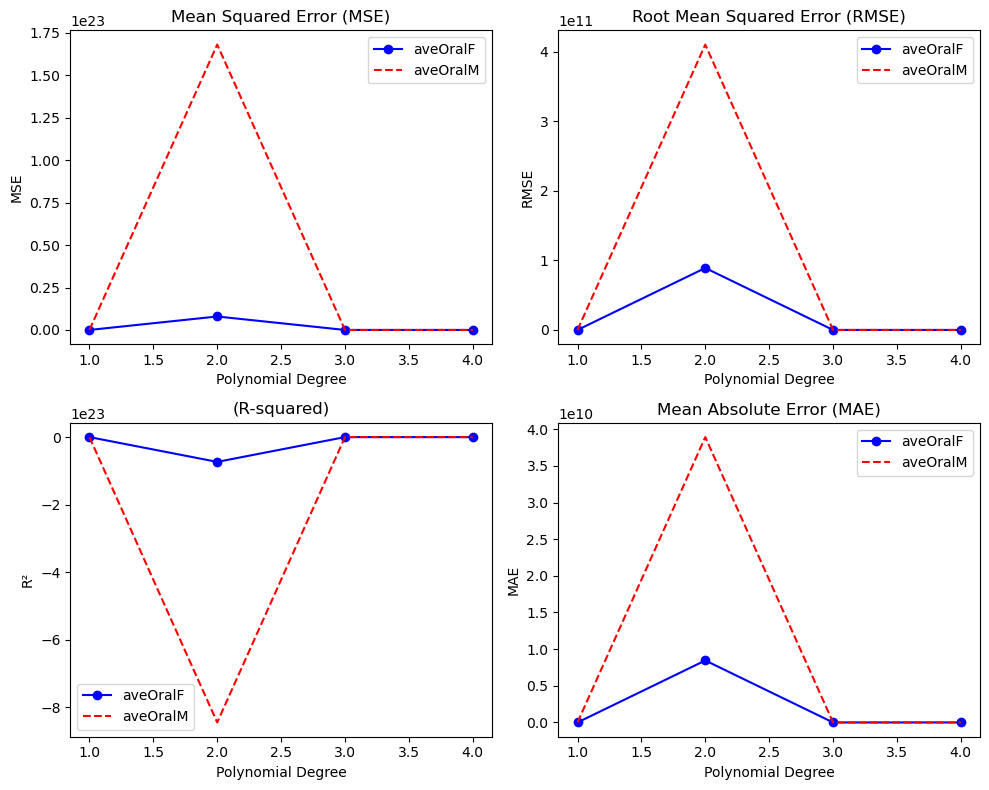

In [194]:
# Do our search on a few large polynomials
degrees = [1, 2, 3, 4]
mseScoresF = []
rmseScoresF = []
r2ScoresF = []
maeScoresF = []
mseScoresM = []
rmseScoresM = []
r2ScoresM = []
maeScoresM = []

# Loop through degrees and calculate the metrics
for degree in degrees:
    xTrain, xTest, yTrain, yTest = train_test_split(dfEncoded, y["aveOralF"], test_size=0.2, shuffle=True, random_state=42)
    # Use standard scaler
    scaler = StandardScaler()
    # Fit to the train and then scale to test to prevent leakage
    xTrain = scaler.fit_transform(xTrain)
    
    xTest = scaler.transform(xTest)
    # Create polynomial features for current degree
    poly = PolynomialFeatures(degree)
    xPoly = poly.fit_transform(xTrain)
    
    # Fit the model
    polyModel = LinearRegression()
    polyModel.fit(xPoly, yTrain)
    
    # Predict
    prediction = polyModel.predict(poly.transform(xTest))
    
    # Calculate the metrics
    mse, rmse, r2, mae = getRegressionMetrics(yTest, prediction)
    
    # Append metrics to the lists
    mseScoresF.append(mse)
    rmseScoresF.append(rmse)
    r2ScoresF.append(r2)
    maeScoresF.append(mae)

for degree in degrees:
    xTrain, xTest, yTrain, yTest = train_test_split(dfEncoded, y["aveOralM"], test_size=0.2, shuffle=True, random_state=42)
    # Use standard scaler
    scaler = StandardScaler()
    # Fit to the train and then scale to test to prevent leakage
    xTrain = scaler.fit_transform(xTrain)
    xTest = scaler.transform(xTest)

    # Create polynomial features for current degree
    poly = PolynomialFeatures(degree)
    xPoly = poly.fit_transform(xTrain)
    
    # Fit the model
    polyModel = LinearRegression()
    polyModel.fit(xPoly, yTrain)
    
    # Predict
    prediction = polyModel.predict(poly.transform(xTest))
    
    # Calculate the metrics
    mse, rmse, r2, mae = getRegressionMetrics(yTest, prediction)
    
    # Append metrics to the lists
    mseScoresM.append(mse)
    rmseScoresM.append(rmse)
    r2ScoresM.append(r2)
    maeScoresM.append(mae)

# Plot the metrics
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(degrees, mseScoresF, marker="o", color="blue", label="aveOralF")
plt.plot(degrees, mseScoresM, linestyle="--", color="red", label="aveOralM")
plt.title("Mean Squared Error (MSE)")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(degrees, rmseScoresF, marker="o", color="blue", label="aveOralF")
plt.plot(degrees, rmseScoresM, linestyle="--", color="red", label="aveOralM")
plt.title("Root Mean Squared Error (RMSE)")
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(degrees, r2ScoresF, marker="o", color="blue", label="aveOralF")
plt.plot(degrees, r2ScoresM, linestyle="--", color="red", label="aveOralM")
plt.title("(R-squared)")
plt.xlabel("Polynomial Degree")
plt.ylabel("R2")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(degrees, maeScoresF, marker="o", color="blue", label="aveOralF")
plt.plot(degrees, maeScoresM, linestyle="--", color="red", label="aveOralM")
plt.title("Mean Absolute Error (MAE)")
plt.xlabel("Polynomial Degree")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()

The results show worse metrics the higher the polynomial degree, this is a symptom of overfitting, we can reduce this by introducing regularisation through Lasso and Ridge (L1, L2) regressions.

We will inspect MSE and R2 with cross-validation as we want to maximise R2 and minimise MSE.

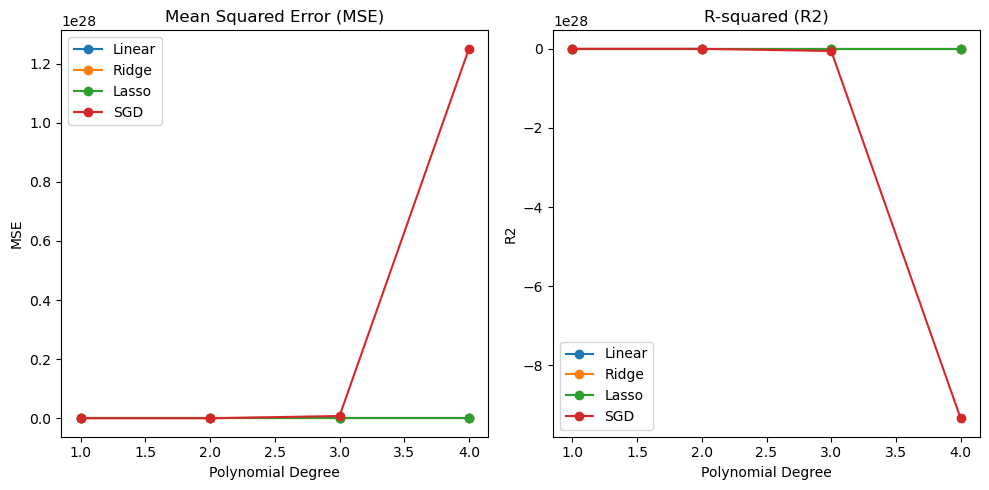

In [6]:
# Do our search on a few large polynomials
degrees = [1, 2, 3, 4]
mseScoresF = {"Linear": [],
              "Ridge": [],
              "Lasso": [], 
              "SGD" : []}
r2ScoresF = {"Linear": [],
             "Ridge": [],
             "Lasso": [],
             "SGD" : []}

# Loop through degrees and calculate the metrics
for degree in degrees:
    poly = PolynomialFeatures(degree)
    xPoly = poly.fit_transform(dfEncoded)
    scaler = StandardScaler()
    xScaled = scaler.fit_transform(xPoly)
    yValues = y["aveOralF"]

    # Linear Regression
    linearModel = LinearRegression()
    mseScores = cross_val_score(linearModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    r2Scores = cross_val_score(linearModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
    
    mseScoresF["Linear"].append(-np.mean(mseScores))
    r2ScoresF["Linear"].append(np.mean(r2Scores))

    # Ridge Regression (L2)
    ridgeModel = Ridge(alpha=1.0)
    mseScores = cross_val_score(ridgeModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    r2Scores = cross_val_score(ridgeModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
    
    mseScoresF["Ridge"].append(-np.mean(mseScores))
    r2ScoresF["Ridge"].append(np.mean(r2Scores))

    # Lasso Regression (L1)
    lassoModel = Lasso(alpha=1.0)
    mseScores = cross_val_score(lassoModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    r2Scores = cross_val_score(lassoModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
    
    mseScoresF["Lasso"].append(-np.mean(mseScores))
    r2ScoresF["Lasso"].append(np.mean(r2Scores))

    # SGD Regression (L2)
    sgdModel = SGDRegressor(penalty="l2", alpha=1, random_state=42)
    mseScores = cross_val_score(sgdModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    r2Scores = cross_val_score(sgdModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
    
    mseScoresF["SGD"].append(-np.mean(mseScores))
    r2ScoresF["SGD"].append(np.mean(r2Scores))
    
    

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for model in mseScoresF:
    plt.plot(degrees, mseScoresF[model], marker="o", label=model)
plt.title("Mean Squared Error (MSE)")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1, 2, 2)
for model in r2ScoresF:
    plt.plot(degrees, r2ScoresF[model], marker="o", label=model)
plt.title("R-squared (R2)")
plt.xlabel("Polynomial Degree")
plt.ylabel("R2")
plt.legend()

plt.tight_layout()
plt.show()

We can see that our overfitting has been fixed by our L1/L2 regularisation, both of which have similar results as they are overlapping in the graphs, to see which degree benefitted the most we can inspect the data to find the lowest MSE and the highest R2.

In [7]:
print(mseScoresF["Linear"])
print(mseScoresF["Lasso"])
print(mseScoresF["Ridge"])
print(mseScoresF["SGD"])

[0.3006343087599057, 1658412.8311054185, 2.219362537565247, 2.452030890459426]
[0.15024571594587116, 0.15024571594587116, 0.15024571594587116, 0.15024571594587116]
[0.08092199698163566, 0.0789223460852236, 0.22379459933000775, 0.31667395553176275]
[0.06726908195155068, 1.3870394663542192e+23, 7.5907082807412966e+25, 1.2505120752992445e+28]


Our lowest MSE was SGD using Ridge at Degree 1: 0.06726908195155068

In [8]:
print(r2ScoresF["Linear"])
print(r2ScoresF["Lasso"])
print(r2ScoresF["Ridge"])
print(r2ScoresF["SGD"])

[-1.0939359938719417, -11372235.900899524, -19.740915109724188, -21.182988953944054]
[-0.011214502586190367, -0.011214502586190367, -0.011214502586190367, -0.011214502586190367]
[0.39563121741469887, 0.39589543094904583, -0.6832069212583669, -1.4725098182376644]
[0.4832368987997128, -9.889314797389719e+23, -5.5842173983074635e+26, -9.336243770218575e+28]


Our best R2 was SGD using Ridge at Degree 2: 0.4832368987997128

It appears that Ridge is the most effective regulariser however it performs nominally better at a degree of 2 when compared to a degree of 1 as it's own regressor but Ridge performs better using the SGD regressor. These results are to be expected, polynomials introduce complexities to the dataset but since we have an already decently performing linear baseline, it is to be expected that a slightly higher complexity model with regularisation can introduce a better fit and subsequently better accuracies.

In [15]:
# Do our search on a few large polynomials
degrees = [1, 2, 3, 4]
mseScoresM = {"Linear": [],
              "Ridge": [],
              "Lasso": [],
              "SGD" : []}
r2ScoresM = {"Linear": [],
             "Ridge": [],
             "Lasso": [],
             "SGD" : []}

# Loop through degrees and calculate the metrics
for degree in degrees:
    poly = PolynomialFeatures(degree)
    xPoly = poly.fit_transform(dfEncoded)
    scaler = StandardScaler()
    xScaled = scaler.fit_transform(xPoly)
    yValues = y["aveOralM"]

    # Linear Regression
    linearModel = LinearRegression()
    mseScores = cross_val_score(linearModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    r2Scores = cross_val_score(linearModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
    
    mseScoresM["Linear"].append(-np.mean(mseScores))
    r2ScoresM["Linear"].append(np.mean(r2Scores))

    # Ridge Regression (L2)
    ridgeModel = Ridge(alpha=1.0)
    mseScores = cross_val_score(ridgeModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    r2Scores = cross_val_score(ridgeModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
    
    mseScoresM["Ridge"].append(-np.mean(mseScores))
    r2ScoresM["Ridge"].append(np.mean(r2Scores))

    # Lasso Regression (L1)
    lassoModel = Lasso(alpha=1.0)
    mseScores = cross_val_score(lassoModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    r2Scores = cross_val_score(lassoModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
    
    mseScoresM["Lasso"].append(-np.mean(mseScores))
    r2ScoresM["Lasso"].append(np.mean(r2Scores))

    # SGD Regression (L2)
    sgdModel = SGDRegressor(penalty="l2", alpha=1, random_state=42)
    mseScores = cross_val_score(sgdModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    r2Scores = cross_val_score(sgdModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
    
    mseScoresM["SGD"].append(-np.mean(mseScores))
    r2ScoresM["SGD"].append(np.mean(r2Scores))

In [16]:
print(mseScoresM["Linear"])
print(mseScoresM["Lasso"])
print(mseScoresM["Ridge"])
print(mseScoresM["SGD"])

[0.5425184850674027, 1999446.1434914197, 5.143245623966937, 4.091564147350361]
[0.26211218050883756, 0.26211218050883756, 0.26211218050883756, 0.26211218050883756]
[0.10116683625150036, 0.6929477764187137, 3.90035483523812, 3.2893204928520574]
[0.08035394489644053, 1.2016984586826562e+23, 6.659248264271823e+25, 7.215921516762298e+27]


Lowest MSE for Monitor-mode is SGD using Ridge at Degree 1: 0.08035394489644053

In [17]:
print(r2ScoresM["Linear"])
print(r2ScoresM["Lasso"])
print(r2ScoresM["Ridge"])
print(r2ScoresM["SGD"])

[-0.8857045329000568, -6835944.899043133, -20.447818346030807, -17.0051285489751]
[-0.02143154610205018, -0.02143154610205018, -0.02143154610205018, -0.02143154610205018]
[0.5974397529554556, -1.3971133184060647, -12.238225617591569, -10.311901664873858]
[0.6511285230566524, -4.5952807073031346e+23, -2.4707040429174474e+26, -2.833600301559146e+28]


Best R2 for Monitor-mode is SGD using Ridge at Degree 1: 0.6511285230566524

These findings show us that Fast-mode performs the best on a linear model but has close metrics with a higher polynomial. In contrast Monitor-mode works best exclusively linear. Both of which have good but not perfect R2 values but very good MSE scores.

# 3.3) Elastic Net

---



We can further investigate the effects of L2 by implementing the ElasticNet model.

In [48]:
# Use standard scaler
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralF"]

# Fit to the model
elasticNetModel = ElasticNet(alpha=0.01, l1_ratio=1.0)

# Cross validation scores
mseScores = cross_val_score(elasticNetModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(elasticNetModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)

print(f"aveOralF - Mean Squared Error (MSE): {mse}")
print(f"aveOralF - R-squared: {r2}")

print("-----------------------------------")

scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralM"]
elasticNetModel = ElasticNet(alpha=0.01, l1_ratio=1.0)
mseScores = cross_val_score(elasticNetModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(elasticNetModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)
print(f"aveOralM - Mean Squared Error (MSE): {mse}")
print(f"aveOralM - R-squared: {r2}")

aveOralF - Mean Squared Error (MSE): 0.0639595357748366
aveOralF - R-squared: 0.5163671935590726
-----------------------------------
aveOralM - Mean Squared Error (MSE): 0.06957015330852998
aveOralM - R-squared: 0.7041400236300561


A low alpha but bias towards L2 provides the best metrics so far, it beats the regularised polynomial for both targets. Monitor-mode still proves to be a harder target to improve as the difference between metrics in each model is very small when compared to Fast-mode. Regardless, the regression predictions are improving.

# 3.4) KNN

---



KNN compares its neighbours to make its own predictions, we can do a very easy exhaustive cross-validation search on this to find all possible hyperparameter values and conclude KNN model preference.

In [8]:
def plotKNNNeighbours(max, x, name):
    scaler = StandardScaler()
    xScaled = scaler.fit_transform(x)
    yValues = y[name]
    
    mseScores = []
    r2Scores = []

    # Loop through neighbors from 1 to max
    for k in range(1, max + 1):
        knnModel = KNeighborsRegressor(n_neighbors=k)

        # Cross validation scores
        mse_scores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
        mseScores.append(np.mean(-mse_scores))
        r2_scores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
        r2Scores.append(np.mean(r2_scores)) 

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max + 1), mseScores, marker="o", color="blue")
    plt.title(f"Mean Squared Error (MSE) - {name}")
    plt.xlabel("Number of Neighbors (K)")
    plt.ylabel("MSE")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, max + 1), r2Scores, marker="o", color="blue")
    plt.title(f"R-squared - {name}")
    plt.xlabel("Number of Neighbors (K)")
    plt.ylabel("R2")
    
    plt.tight_layout()
    plt.show()

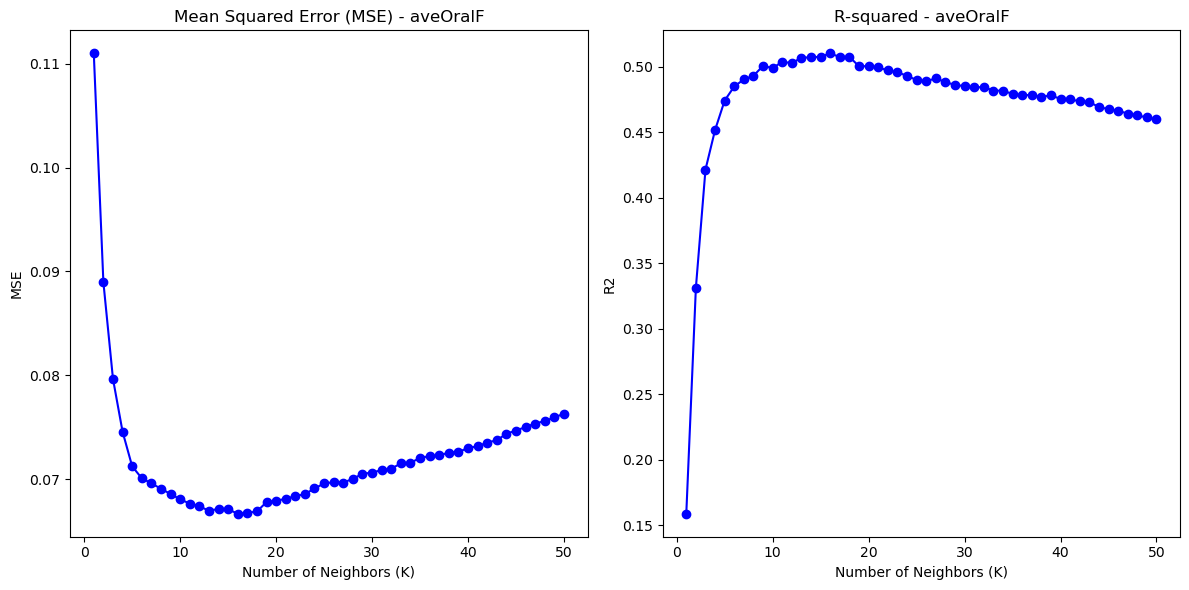

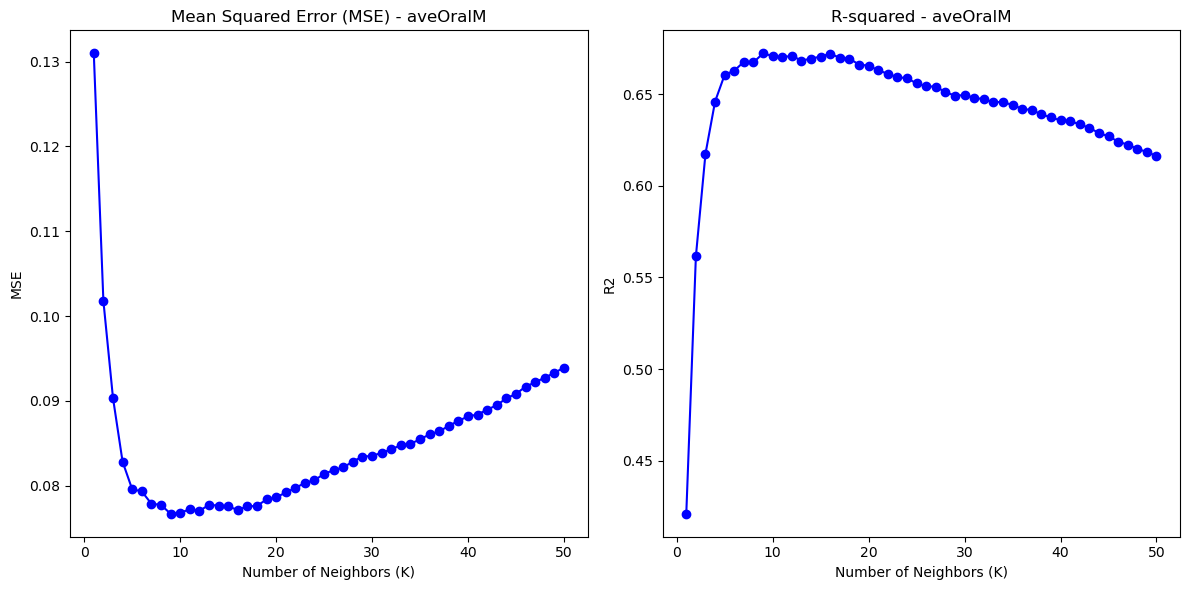

In [9]:
plotKNNNeighbours(50, dfEncoded, "aveOralF")
plotKNNNeighbours(50, dfEncoded, "aveOralM")

Both targets perform very similarly, however we can see the optimal neighbour count being 16 for Fast-mode and 9 for Monitor-Mode.

In [174]:
# Use standard scaler
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralF"]

# Init the model
knnModel = KNeighborsRegressor(n_neighbors=16)

# Cross validation scores
mseScores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)

print(f"aveOralF - Mean Squared Error (MSE): {mse}")
print(f"aveOralF - R-squared: {r2}")
print("-----------------------------------")
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralM"]
knnModel = KNeighborsRegressor(n_neighbors=9)
mseScores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)
print(f"aveOralM - Mean Squared Error (MSE): {mse}")
print(f"aveOralM - R-squared: {r2}")

aveOralF - Mean Squared Error (MSE): 0.06668915038402218
aveOralF - R-squared: 0.5103673800758084
-----------------------------------
aveOralM - Mean Squared Error (MSE): 0.07670893106071733
aveOralM - R-squared: 0.672255444710406


KNN appears to perform nominally worse than the ElasticNet model for Fast-mode. Both MSE and R2 are conserabily higher for Monitor-mode. How can we improve? Unlike other algorithms, KNN does not consider or penalise weak features; it tries to include them. Potentially causing confusion within the model and as a result; harming our metrics!

Let's try the search again dropping the low correlation features we found in our analysis.

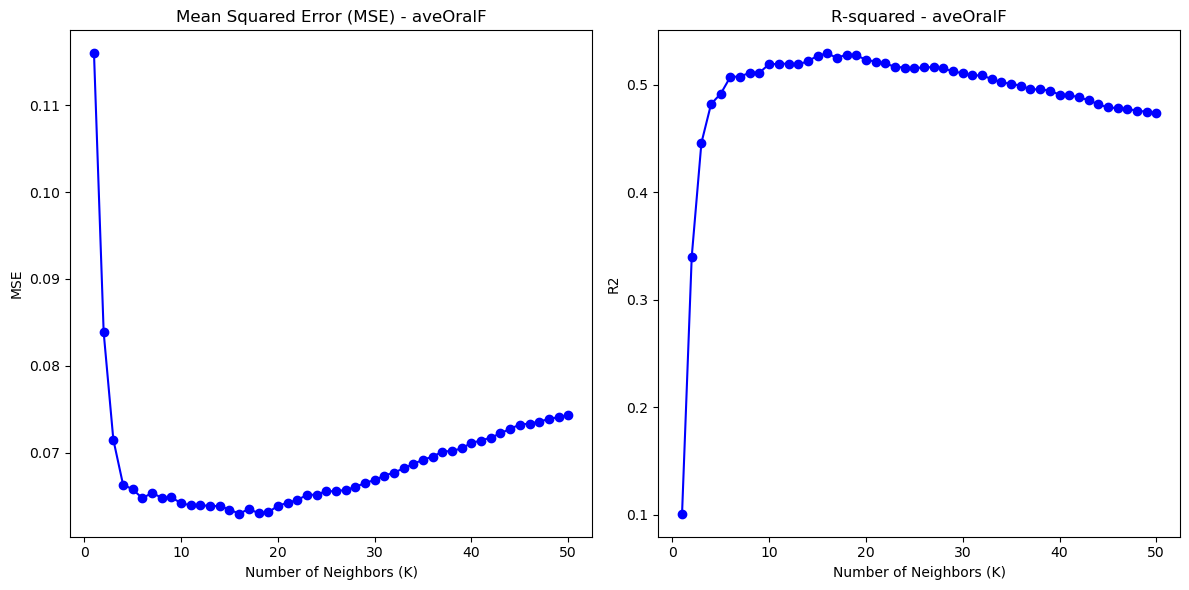

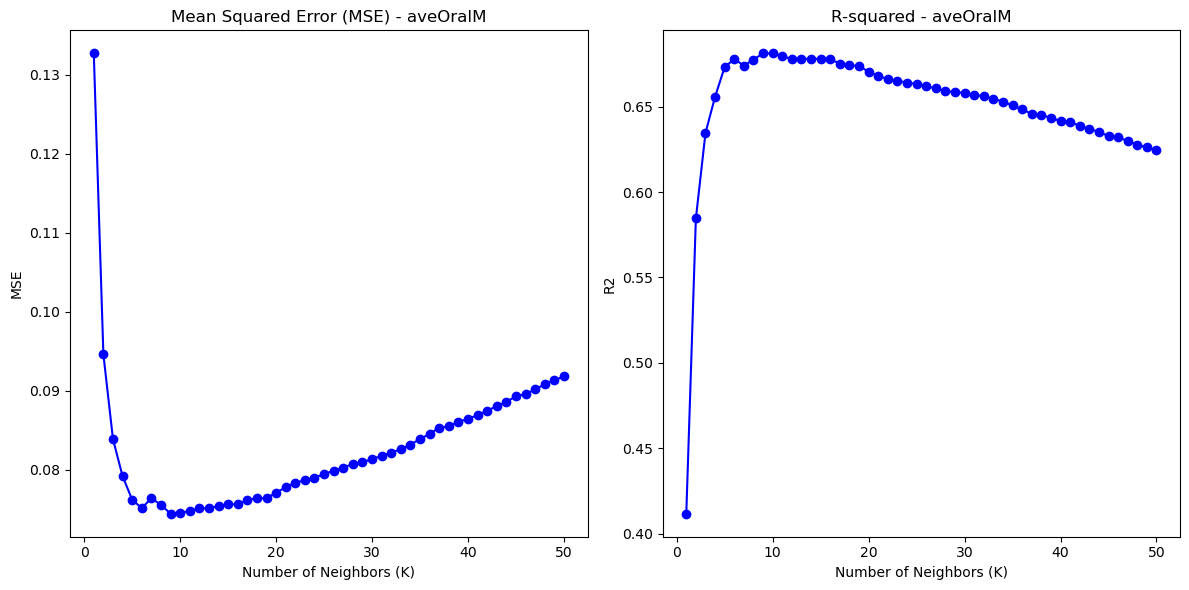

In [10]:
plotKNNNeighbours(50, dfEncoded.drop(columns=lowCorrFeatures), "aveOralF")
plotKNNNeighbours(50, dfEncoded.drop(columns=lowCorrFeatures), "aveOralM")

The graphs have changed slightly but their optimal neighbour values remain the same.

In [11]:
# Use standard scaler
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded.drop(columns=lowCorrFeatures))
yValues = y["aveOralF"]

# Init the model
knnModel = KNeighborsRegressor(n_neighbors=16)

# Cross validation scores
mseScores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)

print(f"aveOralF - Mean Squared Error (MSE): {mse}")
print(f"aveOralF - R-squared: {r2}")
print("-----------------------------------")
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded.drop(columns=lowCorrFeatures))
yValues = y["aveOralM"]
knnModel = KNeighborsRegressor(n_neighbors=9)
mseScores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(knnModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)
print(f"aveOralM - Mean Squared Error (MSE): {mse}")
print(f"aveOralM - R-squared: {r2}")

aveOralF - Mean Squared Error (MSE): 0.06299250245626267
aveOralF - R-squared: 0.5292876452686723
-----------------------------------
aveOralM - Mean Squared Error (MSE): 0.07443446985009416
aveOralM - R-squared: 0.6812758425124447


As predicted, removing weak features has improved both target metrics, KNN now performs better than our ElasticNet findings for Fast-mode however Monitor-mode still doesn't produce strong enough results to beat ElasticNet.

# 3.5) Fine-Tuning Best Regression Models

---



Now that we've compared a few models, we have found that KNN is the best model for aveOralF and ElasticNet is the best model for aveOralM.

To confirm KNN as the best model for aveOralF we can do a hyperparameter search on the ElasticNet model to see if we can find an optimal hyperparameter set which will beat the KNN accuracy.

In [41]:
# Define hyperparameter grid
params = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10],
    "l1_ratio": [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28]}

scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralF"]

elasticNet = ElasticNet()
gridSearch = GridSearchCV(elasticNet, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
gridSearch.fit(xScaled, yValues)

# Print best params
print("Best parameters:", gridSearch.best_params_)

Best parameters: {'alpha': 0.01, 'l1_ratio': 0.26}


In [42]:
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralF"]
elasticNetModel = ElasticNet(alpha=0.01, l1_ratio=0.26)

# Cross validation scores
mseScores = cross_val_score(elasticNetModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(elasticNetModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)

print(f"aveOralF - Mean Squared Error (MSE): {mse}")
print(f"aveOralF - R-squared: {r2}")

aveOralF - Mean Squared Error (MSE): 0.06323672112434334
aveOralF - R-squared: 0.5172162537516101


Even after a hyperparam search aveOralF cannot beat the KNN values, ultimately having a delta of `0.00024421866808067`, `0.0120713915170622` for MSE and R2 respectively.

In [34]:
# Define hyperparameter grid
params = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10],
    "l1_ratio": [0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39]}

scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralM"]

elasticNet = ElasticNet()
gridSearch = GridSearchCV(elasticNet, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
gridSearch.fit(xScaled, yValues)

# Print best params
print("Best parameters:", gridSearch.best_params_)

Best parameters: {'alpha': 0.01, 'l1_ratio': 0.37}


In [46]:
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)
yValues = y["aveOralM"]
elasticNetModel = ElasticNet(alpha=0.01, l1_ratio=0.37)

# Cross validation scores
mseScores = cross_val_score(elasticNetModel, xScaled, yValues, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
mse = -np.mean(mseScores)
r2Scores = cross_val_score(elasticNetModel, xScaled, yValues, cv=5, scoring="r2", n_jobs=-1)
r2 = np.mean(r2Scores)

print(f"aveOralM - Mean Squared Error (MSE): {mse}")
print(f"aveOralM - R-squared: {r2}")

aveOralM - Mean Squared Error (MSE): 0.06874331041431588
aveOralM - R-squared: 0.7067772018111205


Hyperparameter tuning has allowed for nominally improved metrics, regardless these results make the best fit and accuracy for Monitor-Mode.

To conclude, our best models and hyperparameter values for aveOralF and aveOralM are:

aveOralF : KNN - 16 Neighbours - `MSE 0.06299250245626267`, `R2 0.5292876452686723`

aveOralM : ElasticNet - 0.01 Alpha, 0.37 l1_ratio - `MSE 0.06874331041431588`, `R2 0.7067772018111205`

# **4) CLASSIFICATION MODELS**

---



*   Establishing a common-sense baseline
*   Logistic Regression
*   Simple Neural Model
*   Improved Neural Model with Regularisation
*   Dual-Path Neural Model
*   Fine-Tuning Single Path
*   Fine-Tuning Dual Path
*   Findings of Tuned Neural Models

# 4.1) Establishing a common-sense baseline

---



Now that the regression section has been concluded, we can move onto a neural approach, our results suggest that the solution is intrinsically simple as it can be linearly solved, therefore a neural model should not need to be complex in nature but should be able to beat a common-sense baseline at the very least.

To convert our continuous targets into classification, we can convert them into a binary (0/1) if they're below or above the 37.5 C threshold to constitute as a fever.

In [7]:
yClassification = y.copy()
yClassification["aveOralF_Binary"] = (y["aveOralF"] >= 37.5).astype(int)
yClassification["aveOralM_Binary"] = (y["aveOralM"] >= 37.5).astype(int)
# Check we have some actual positive values
print(np.where(yClassification["aveOralF_Binary"] == 1)[0])
print(np.where(yClassification["aveOralM_Binary"] == 1)[0])

[  66   72   81   98  104  122  136  139  155  156  261  262  301  341
  384  444  475  487  490  496  522  533  560  645  648  650  653  688
  691  697  699  707  708  709  712  722  731  749  753  754  756  760
  761  785  799  800  803  804  809  814  828  831  839  844  845  867
  874  887  930  931  953  956  974  996 1009]
[  14   59   66   72   78   81   93   98  104  122  129  132  136  139
  146  150  155  156  212  261  262  272  292  301  306  314  325  341
  344  358  361  367  384  444  447  457  466  475  487  490  495  522
  533  540  546  555  560  610  640  645  648  650  668  686  688  691
  697  699  703  707  708  709  711  712  721  722  724  731  737  747
  749  751  753  754  760  761  765  770  774  785  791  793  799  800
  803  804  809  810  814  823  828  831  836  837  839  842  844  845
  867  874  887  898  930  931  951  953  956  974  996 1009 1015]


In [8]:
oralFMean = yClassification["aveOralF_Binary"].mean()
oralMMean = yClassification["aveOralM_Binary"].mean()
print("aveOralF Baseline", 100 - oralFMean * 100)
print("aveOralM Baseline", 100 - oralMMean * 100)

aveOralF Baseline 93.61493123772102
aveOralM Baseline 89.09626719056975


In order to have statistical power, we need to beat a very high classification accuracy, this is due to the significant class imbalance between true positives and true negatives.

# 4.2) Logistic Regression

---



Before indulging in a custom neural network, we can try a classifier regression such as Logistic Regression, this can help us understand the type of performance we should be trying to beat above baseline.

The metrics to focus on are Accuracy (Classification Accuracy), Precision (False Positive Rate), Recall (Ratio of True Positives Identified), AUC-ROC (Understanding the fit of the model), MSE (Regression comparison metric to see if fully-dense neural models are better).

In [231]:
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfEncoded)

# Logistic Regression with class balancing
logReg = LogisticRegression(class_weight="balanced")

# Cross-validation scores
yValues = yClassification["aveOralF_Binary"]
accuracyScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring="accuracy", n_jobs=-1)
precisionScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring="precision", n_jobs=-1)
recallScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring="recall", n_jobs=-1)
aucScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring="roc_auc", n_jobs=-1)
mseScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) * -1

print(f"aveOralF - Accuracy: {np.mean(accuracyScores):.4f}")
print(f"aveOralF - Precision: {np.mean(precisionScores):.4f}")
print(f"aveOralF - Recall: {np.mean(recallScores):.4f}")
print(f"aveOralF - AUC-ROC: {np.mean(aucScores):.4f}")
print(f"aveOralF - MSE: {np.mean(mseScores):.4f}")

print("-----------------------------------")

# Repeat for other target
yValues = yClassification["aveOralM_Binary"]
accuracyScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring="accuracy", n_jobs=-1)
precisionScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring="precision", n_jobs=-1)
recallScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring="recall", n_jobs=-1)
aucScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring="roc_auc", n_jobs=-1)
mseScores = cross_val_score(logReg, xScaled, yValues, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) * -1

print(f"aveOralM - Accuracy: {np.mean(accuracyScores):.4f}")
print(f"aveOralM - Precision: {np.mean(precisionScores):.4f}")
print(f"aveOralM - Recall: {np.mean(recallScores):.4f}")
print(f"aveOralM - AUC-ROC: {np.mean(aucScores):.4f}")
print(f"aveOralM - MSE: {np.mean(mseScores):.4f}")

aveOralF - Accuracy: 0.9430
aveOralF - Precision: 0.5542
aveOralF - Recall: 0.8923
aveOralF - AUC-ROC: 0.9565
aveOralF - MSE: 0.0570
-----------------------------------
aveOralM - Accuracy: 0.9224
aveOralM - Precision: 0.6186
aveOralM - Recall: 0.8648
aveOralM - AUC-ROC: 0.9645
aveOralM - MSE: 0.0776


The results illustrate the need for the other metrics outside of accuracy, class imbalance causes the highly persuasive accuracy metric and therefore we can't judge the performance from that metric alone.

Although we are beating baseline, we have a moderately low Precision, meaning that when the regression wants to predict a class it is usually quite right wrong about it. Recall shows that we are predicting many of the true positives, as there are so few true positives this is not necessarily evidence for good learning. Ideally we would like a higher Precision but not sacrifice Recall, this is because the priority should be to reduce false positives and be correct about feverish symptoms.

These two metrics share an inverse relationship, as Precision increases,  Recall decreases. The only way to improve this is by building better models which will allow for both metrics to improve regardless of thresholding.

# 4.3) Simple Neural Model

---



We can use tensorflow to build a simple fully-connected neural dense network.

We will need to investigate model learning by comparing training to a validation set, we can visualise this by using training plots:

In [21]:
def plotAccuracy(history):
    trainAcc = history.history["accuracy"]
    valAcc = history.history["val_accuracy"]
    epochs = np.arange(len(trainAcc))
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, trainAcc, linestyle="-", label="Training Accuracy")
    plt.plot(epochs, valAcc, linestyle="-", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Training Plot")
    plt.show()

def plotLoss(history):
    trainLoss = history.history["loss"]
    valLoss = history.history["val_loss"]
    epochs = np.arange(len(trainLoss))
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, trainLoss, linestyle="-", label="Training Loss")
    plt.plot(epochs, valLoss, linestyle="-", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Training Plot")
    plt.show()

Additionally we can produce the other metrics with binary thresholding.

In [22]:
def printClassificationMetrics(model, truth, test, binaryThreshold, name):
    # Run prediction with threshold
    prediction = (model.predict(test) >= binaryThreshold).astype(int)

    # Classification Accuracy
    accuracy = accuracy_score(truth, prediction)
    print(f"{name} - Accuracy: {accuracy:.4f}")

    # Precision
    precision = precision_score(truth, prediction)
    print(f"{name} - Precision: {precision:.4f}")

    # Recall
    recall = recall_score(truth, prediction)
    print(f"{name} - Recall: {recall:.4f}")

    # ROC-AUC
    roc_auc = roc_auc_score(truth, prediction)
    print(f"{name} - ROC-AUC: {roc_auc:.4f}")

    # MSE (Mean Squared Error)
    mse = mean_squared_error(truth, prediction)
    print(f"{name} - MSE: {mse:.4f}")

Our setup involves a hold-out composed of the 70/20/10 split, although we are working with a small dataset it is important to understand training effectiveness to get the most robust model which we can generalise using cross-validation once tuned. We also apply class weights and address any leakage by scaling the data for test and validation using the transformation based on the training data alone.

Monitor-mode will be used as target of choice as hold-out validation works better the bigger the dataset, is the harder target to predict and subsequently will produce a good foundation when tuning for Fast-mode.

In [23]:
# Define the target
yValues = yClassification["aveOralM_Binary"]

# Split the data into train, val, test sets (70/20/10 split)
xTrain, xVal, yTrain, yVal = train_test_split(dfEncoded, yValues, test_size=0.3, stratify=yValues, shuffle=True, random_state=42)
xVal, xTest, yVal, yTest = train_test_split(xVal, yVal, test_size=0.66, stratify=yVal, shuffle=True, random_state=42)

scaler = StandardScaler()
# Transform to only the train set
xTrain = scaler.fit_transform(xTrain)
# Use that scaler for our unseen data
xVal = scaler.transform(xVal)
xTest = scaler.transform(xTest) 

# Compute class weights as we have a big imbalance
classWeights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(yTrain),
    y=yTrain)
classWeights = dict(enumerate(classWeights))

In [24]:
# Clear the backend before doing any training
tf.keras.backend.clear_session()
# Build the Neural Model
baseModel = Sequential()
# Input layer with the number of features
baseModel.add(Dense(128, input_dim=xTrain.shape[1], activation="relu"))
# Output layer (1 neuron for binary classification)
baseModel.add(Dense(1, activation="sigmoid"))

# Compile using adam and binary crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
baseModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Train 
history = baseModel.fit(xTrain, yTrain,
                    validation_data=(xVal, yVal),
                    epochs=50,
                    batch_size=16,
                    class_weight=classWeights)

Epoch 1/50
45/45 [==============================] - 1s 8ms/step - loss: 0.4274 - accuracy: 0.5983 - val_loss: 0.4437 - val_accuracy: 0.7596
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.2559 - accuracy: 0.8174 - val_loss: 0.3452 - val_accuracy: 0.8269
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.2132 - accuracy: 0.8820 - val_loss: 0.2881 - val_accuracy: 0.8654
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1910 - accuracy: 0.9087 - val_loss: 0.2988 - val_accuracy: 0.8558
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1799 - accuracy: 0.9115 - val_loss: 0.2448 - val_accuracy: 0.8750
Epoch 6/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1652 - accuracy: 0.9213 - val_loss: 0.1925 - val_accuracy: 0.9038
Epoch 7/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1546 - accuracy: 0.9326 - val_loss: 0.1796 - val_accuracy: 0.9231
Epoch 8/50
45/45 [==

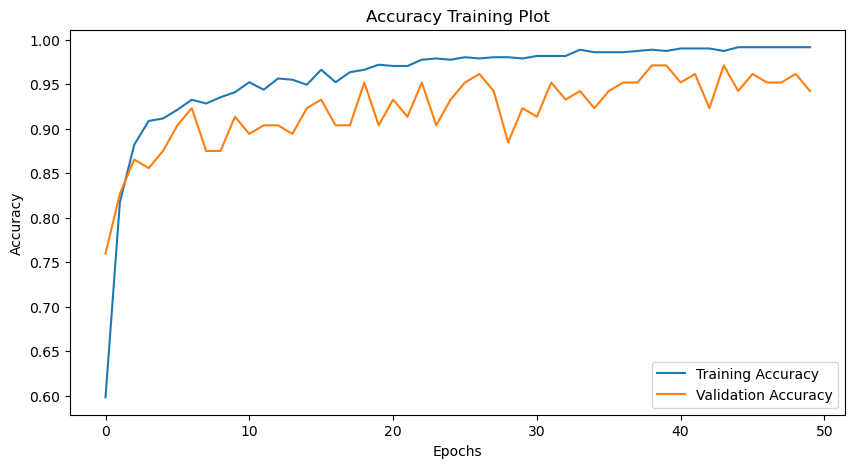

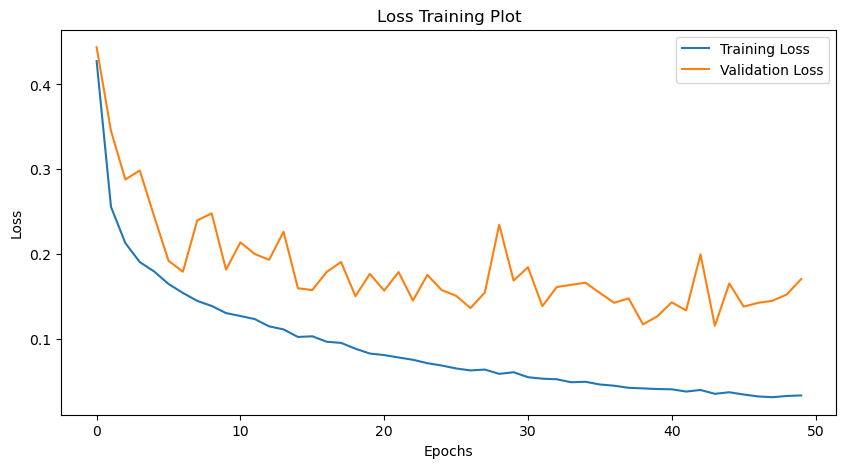

In [25]:
# Plot training graphs
plotAccuracy(history)
plotLoss(history)

Training graphs exhibits some underfitting: Validation Loss diverges at approximately 20 Epochs but continues to learn with a large loss whilst Training Accuracy reaches 1.000 as Validation Accuracy plateus at approximately 20 Epochs.

In [26]:
# Evaluate the model and get metrics
printClassificationMetrics(baseModel, yTest, xTest, 0.50, "aveOralM")

7/7 [==============================] - 0s 1ms/step
aveOralM - Accuracy: 0.9554
aveOralM - Precision: 0.7826
aveOralM - Recall: 0.8182
aveOralM - ROC-AUC: 0.8952
aveOralM - MSE: 0.0446


Our metrics show similar performance to that of the Logistic Model, this is an expected result as both models are not regularised. We seem to be getting better than regression metrics when looking at MSE, we are almost 2x better.

We can try a higher capacity model to see if it gives us better metrics.

In [27]:
tf.keras.backend.clear_session()
largerCapacityModel = Sequential()
largerCapacityModel.add(Dense(128, input_dim=xTrain.shape[1], activation="relu"))
# Introduce a hidden middle layer
largerCapacityModel.add(Dense(64, activation="relu"))
largerCapacityModel.add(Dense(1, activation="sigmoid"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
largerCapacityModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = largerCapacityModel.fit(xTrain, yTrain,
                    validation_data=(xVal, yVal),
                    epochs=50,
                    batch_size=16,
                    class_weight=classWeights)

Epoch 1/50
45/45 [==============================] - 1s 9ms/step - loss: 0.3677 - accuracy: 0.7219 - val_loss: 0.3323 - val_accuracy: 0.8077
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.2330 - accuracy: 0.8834 - val_loss: 0.2439 - val_accuracy: 0.8750
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1960 - accuracy: 0.8989 - val_loss: 0.2824 - val_accuracy: 0.8558
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1715 - accuracy: 0.9438 - val_loss: 0.2681 - val_accuracy: 0.8654
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1560 - accuracy: 0.9242 - val_loss: 0.1950 - val_accuracy: 0.9038
Epoch 6/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1456 - accuracy: 0.9494 - val_loss: 0.2306 - val_accuracy: 0.8750
Epoch 7/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1241 - accuracy: 0.9438 - val_loss: 0.1947 - val_accuracy: 0.9327
Epoch 8/50
45/45 [==

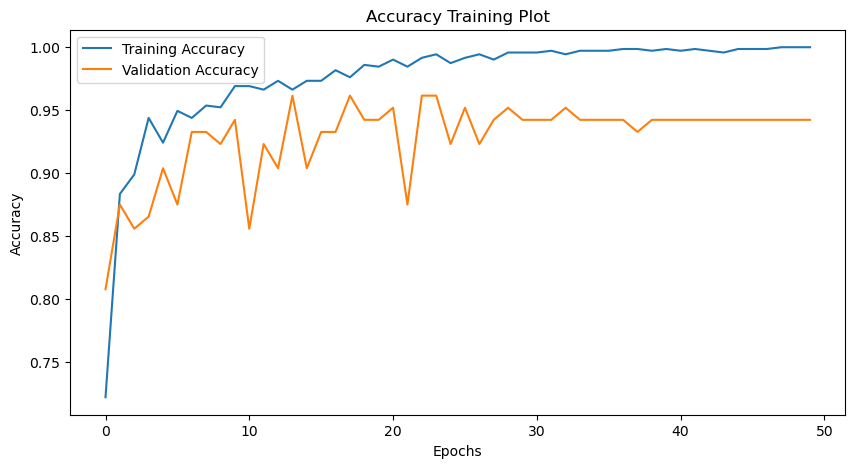

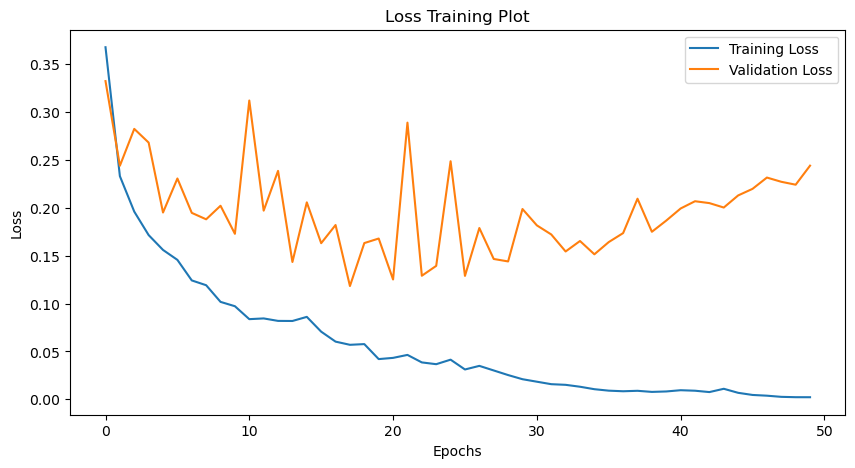

In [28]:
# Plot training graphs
plotAccuracy(history)
plotLoss(history)

In [29]:
# Evaluate the model and get metrics
printClassificationMetrics(largerCapacityModel, yTest, xTest, 0.50, "aveOralM")

7/7 [==============================] - 0s 1ms/step
aveOralM - Accuracy: 0.9604
aveOralM - Precision: 0.7917
aveOralM - Recall: 0.8636
aveOralM - ROC-AUC: 0.9179
aveOralM - MSE: 0.0396


Our metrics have improved over the previous models however we see that the model is now seriously overfitting, this is evidenced by the training graphs where our validation loss and accuracy worsen after 20 Epochs. Any further capacity enlargening will not help the model and make the overfitting worse. We can introduce regularisation techniques such as dropout and l1/l2 on the neuron layers to reduce overfitting.

# 4.4) Improved Neural Model with Regularisation

---



Now that we have an idea for the model and the capacity, we can introduce regularisation to remedy the overfitting.

We can implement a kernel regulariser using l2 and we can also add dropout layers. Kernel regulariser helps overfitting because it prevents larger dominating. Dropout helps overfitting because it randomly deactivates a given number of neurons to prevent the model from being overly reliant on some features.

In [50]:
tf.keras.backend.clear_session()
remedyModel = Sequential()
# Introduce the l2 regulariser
remedyModel.add(Dense(128, input_dim=xTrain.shape[1], activation="relu", kernel_regularizer=l2(0.005)))
# Dropout 30% of the 128 neurons
remedyModel.add(Dropout(0.3))
remedyModel.add(Dense(64, activation="relu", kernel_regularizer=l2(0.003)))
# Dorpout 20% of the 64 neurons
remedyModel.add(Dropout(0.2)) 
remedyModel.add(Dense(1, activation="sigmoid"))

# Additionally half learning rate to prevent quick gradient descent and stablise training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
remedyModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = remedyModel.fit(xTrain, yTrain,
                    validation_data=(xVal, yVal),
                    epochs=50,
                    batch_size=16,
                    class_weight=classWeights)

Epoch 1/50
45/45 [==============================] - 1s 9ms/step - loss: 1.1708 - accuracy: 0.7008 - val_loss: 0.9767 - val_accuracy: 0.7692
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 0.8308 - accuracy: 0.8104 - val_loss: 0.8743 - val_accuracy: 0.7885
Epoch 3/50
45/45 [==============================] - 0s 7ms/step - loss: 0.7410 - accuracy: 0.8441 - val_loss: 0.7961 - val_accuracy: 0.7981
Epoch 4/50
45/45 [==============================] - 0s 7ms/step - loss: 0.6948 - accuracy: 0.8708 - val_loss: 0.7275 - val_accuracy: 0.8462
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 0.6539 - accuracy: 0.8610 - val_loss: 0.6842 - val_accuracy: 0.8654
Epoch 6/50
45/45 [==============================] - 0s 8ms/step - loss: 0.5971 - accuracy: 0.8890 - val_loss: 0.5891 - val_accuracy: 0.9038
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 0.5837 - accuracy: 0.9087 - val_loss: 0.5982 - val_accuracy: 0.8942
Epoch 8/50
45/45 [==

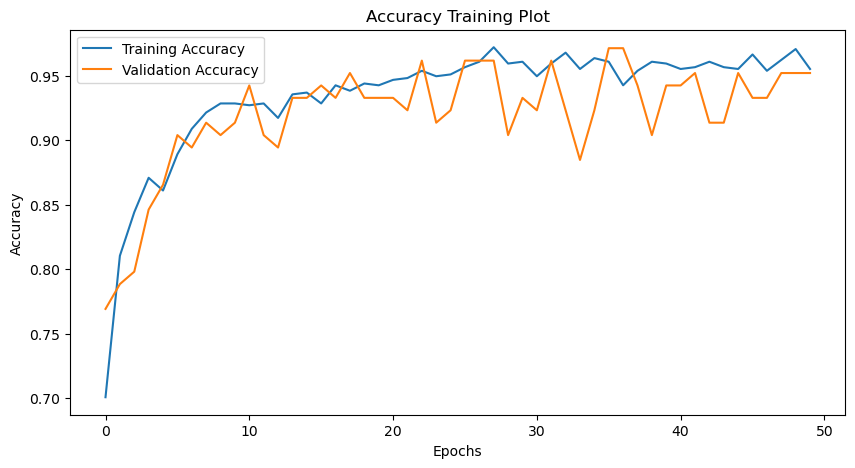

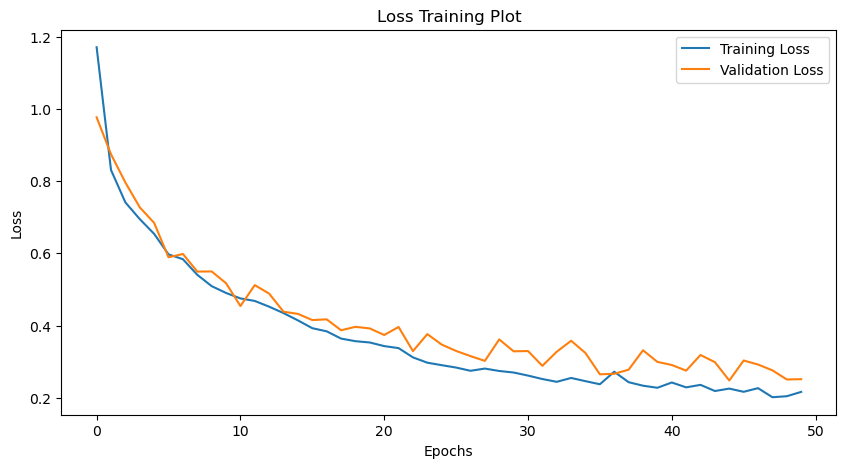

In [51]:
# Plot training graphs
plotAccuracy(history)
plotLoss(history)

Our training graphs have improved, validation and training improve at the same rate across all 50 Epochs. What about the metrics?

In [57]:
printClassificationMetrics(remedyModel, yTest, xTest, 0.50, "aveOralM")

7/7 [==============================] - 0s 1ms/step
aveOralM - Accuracy: 0.9604
aveOralM - Precision: 0.7917
aveOralM - Recall: 0.8636
aveOralM - ROC-AUC: 0.9179
aveOralM - MSE: 0.0396


It seems as if our metrics havn't improved? That would be odd, we already know we are dealing with a small dataset therefore it's not uncommon to not see much movement in our values, but going from an overfitting to a more robust model has proven improvements in our regression experiments, so what could be the cause here?

The improvements are hidden within our binary threshold, we currently classify the sigmoid probability by comparing it to 0.50, this is the default value. This value is arbitrary and neither swings towards Precision or Recall, however since we are interested in improving Precision, i.e, correctly identifying feverish behaviour without predicting many false positives, we can increase the threshold to subject the sigmoid probability to a higher margin to beat. We should expect improvements in Precision and a slightly worsened Recall.

In [58]:
printClassificationMetrics(remedyModel, yTest, xTest, 0.90, "aveOralM")

7/7 [==============================] - 0s 1ms/step
aveOralM - Accuracy: 0.9653
aveOralM - Precision: 0.9412
aveOralM - Recall: 0.7273
aveOralM - ROC-AUC: 0.8609
aveOralM - MSE: 0.0347


We can see that the higher threshold has caused the changes we were expecting, our Precision has become to a very acceptable level at the sacrifice of 10% of Recall. We can compare this threshold to the overfitting model to confirm that the regularised model is indeed more robust.

In [59]:
printClassificationMetrics(largerCapacityModel, yTest, xTest, 0.90, "aveOralM")

7/7 [==============================] - 0s 1ms/step
aveOralM - Accuracy: 0.9554
aveOralM - Precision: 0.7826
aveOralM - Recall: 0.8182
aveOralM - ROC-AUC: 0.8952
aveOralM - MSE: 0.0446


All metrics decrease with the higher threshold here. This model doesn't beat itself or the regularised model at a higher threshold. This is because the model is not confident enough in its predictions and subsequently relies on the lower threshold to give it generalisation power.

A quick check on Fast-mode shows that both targets are benefiting from this new model and the parallel effects on training, regularisation and thresholding demonstrates that Monitor-mode is the correct target to conduct the hold-out experiments on:

In [60]:
printClassificationMetrics(remedyModel, yTest, xTest, 0.90, "aveOralF")
printClassificationMetrics(largerCapacityModel, yTest, xTest, 0.90, "aveOralF")

7/7 [==============================] - 0s 1ms/step
aveOralF - Accuracy: 0.9653
aveOralF - Precision: 0.9412
aveOralF - Recall: 0.7273
aveOralF - ROC-AUC: 0.8609
aveOralF - MSE: 0.0347
7/7 [==============================] - 0s 1ms/step
aveOralF - Accuracy: 0.9554
aveOralF - Precision: 0.7826
aveOralF - Recall: 0.8182
aveOralF - ROC-AUC: 0.8952
aveOralF - MSE: 0.0446


# 4.5) Dual-Path Neural Model

---



Another approach to a neural model is to split our features between weak and strong and have a separate neural layer for each before converging into the final probability, this dual-path solution effectively prevents the weak features from absorbing neurons that may be useful for more important features whilst retaining a low capacity overall which will help keep the model simple and prevent further overfitting.

We can split our dataset into the weak and the strong by using our correlation findings from the analysis similar to what was done with KNN. However we will not just drop those features, we will drop and append the weak features to the end of the dataframe so we can easily split them when it comes to training splits.

In [10]:
dfEncodedStrong = dfEncoded.drop(columns=lowCorrFeatures)
dfEncodedWeak = dfEncoded[lowCorrFeatures]
dfDual = pd.concat([dfEncodedStrong, dfEncodedWeak], axis=1)
print(dfDual.head())
print(dfEncodedStrong.head())

   Max1R13_1  Max1L13_1  aveAllR13_1  aveAllL13_1    T_RC1  T_RC_Dry1  \
0    35.0300    35.3775      34.4000      34.9175  34.9850    34.9850   
1    34.5500    34.5200      33.9300      34.2250  34.7100    34.6325   
2    35.6525    35.5175      34.2775      34.8000  35.6850    35.6675   
3    35.2225    35.6125      34.3850      35.2475  35.2075    35.2000   
4    35.5450    35.6650      34.9100      35.3675  35.6025    35.4750   

   T_RC_Wet1  T_RC_Max1    T_LC1  T_LC_Dry1  ...  Age_26-30  Age_31-40  \
0    34.7625    35.0325  35.3375    35.3375  ...      False      False   
1    34.6400    34.7425  34.5600    34.5375  ...      False       True   
2    35.6150    35.7175  35.5025    35.5025  ...      False      False   
3    35.1175    35.2250  35.5950    35.5950  ...      False      False   
4    35.5700    35.6400  35.6400    35.6400  ...      False      False   

   Age_41-50  Age_51-60  Age_>60  Ethnicity_Asian  \
0       True      False    False            False   
1      Fal

We can see that our Strong Features dataframe has 26 elements, this will be the inclusive index for splitting our inputs.

We will also require a modified metrics list because we have 2 inputs for the new model:

In [33]:
def printClassificationMetricsDualPath(model, truth, testStrong, testWeak, binaryThreshold, name):
    # Run prediction with threshold
    prediction = (model.predict([testStrong, testWeak]) >= binaryThreshold).astype(int)

    # Classification Accuracy
    accuracy = accuracy_score(truth, prediction)
    print(f"{name} - Accuracy: {accuracy:.4f}")

    # Precision
    precision = precision_score(truth, prediction)
    print(f"{name} - Precision: {precision:.4f}")

    # Recall
    recall = recall_score(truth, prediction)
    print(f"{name} - Recall: {recall:.4f}")

    # ROC-AUC
    roc_auc = roc_auc_score(truth, prediction)
    print(f"{name} - ROC-AUC: {roc_auc:.4f}")

    # MSE (Mean Squared Error)
    mse = mean_squared_error(truth, prediction)
    print(f"{name} - MSE: {mse:.4f}")

We don't need new weights or scaler as our dataframe is effectively the same but its good practice anytime the train split has been altered.

In [18]:
# Define the target
yValues = yClassification["aveOralM_Binary"]
# Split the data the same as before but using the dual dataframe
xTrain, xVal, yTrain, yVal = train_test_split(dfDual, yValues, test_size=0.3, stratify=yValues, shuffle=True, random_state=42)
xVal, xTest, yVal, yTest = train_test_split(xVal, yVal, test_size=0.66, stratify=yVal, shuffle=True, random_state=42)

scaler = StandardScaler()
# Transform to only the train set
xTrain = scaler.fit_transform(xTrain)
# Use that scaler for our unseen data
xVal = scaler.transform(xVal)
xTest = scaler.transform(xTest) 

# Compute class weights as we have a big imbalance
classWeights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(yTrain),
    y=yTrain)
classWeights = dict(enumerate(classWeights))

We can implement 2 branches, the strong path can have a higher capacity as it has more features, the weaker branch can have half capacity as it has less features but also to not underfit any of the weak features but give ample capacity.

In [47]:
tf.keras.backend.clear_session()
# Define input layers for each feature group
inputStrong = Input(shape=(26,), name="strongFeatures")
inputWeak = Input(shape=(xTrain.shape[1] - 26,), name="weakFeatures")

# Separate dense layers for strong and weak features
strongPath = Dense(64, activation="relu")(inputStrong)
strongPath = Dense(32, activation="relu")(strongPath)
weakPath = Dense(32, activation="relu")(inputWeak)
weakPath = Dense(16, activation="relu")(weakPath)

# Concatenate both paths
merged = Concatenate()([strongPath, weakPath])
output = Dense(1, activation="sigmoid")(merged)

# Model setup
dualPathModel = Model(inputs=[inputStrong, inputWeak], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
dualPathModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Split the dataset up to and including the first 26 elements for strong
xTrainStrong = xTrain[:, :26]
xTrainWeak = xTrain[:, 26:]
xValStrong = xVal[:, :26]
xValWeak = xVal[:, 26:]
xTestStrong = xTest[:, :26]
xTestWeak = xTest[:, 26:]

history = dualPathModel.fit(
    [xTrainStrong, xTrainWeak], yTrain,
    validation_data=([xValStrong, xValWeak], yVal),
    epochs=50,
    batch_size=16,
    class_weight=classWeights
)

Epoch 1/50
45/45 [==============================] - 1s 10ms/step - loss: 0.3604 - accuracy: 0.7500 - val_loss: 0.3765 - val_accuracy: 0.7981
Epoch 2/50
45/45 [==============================] - 0s 8ms/step - loss: 0.2468 - accuracy: 0.8497 - val_loss: 0.3565 - val_accuracy: 0.8173
Epoch 3/50
45/45 [==============================] - 0s 8ms/step - loss: 0.2116 - accuracy: 0.8764 - val_loss: 0.2701 - val_accuracy: 0.8558
Epoch 4/50
45/45 [==============================] - 0s 8ms/step - loss: 0.1929 - accuracy: 0.9059 - val_loss: 0.2661 - val_accuracy: 0.8558
Epoch 5/50
45/45 [==============================] - 0s 8ms/step - loss: 0.1737 - accuracy: 0.9129 - val_loss: 0.1840 - val_accuracy: 0.9423
Epoch 6/50
45/45 [==============================] - 0s 8ms/step - loss: 0.1701 - accuracy: 0.9298 - val_loss: 0.2739 - val_accuracy: 0.8462
Epoch 7/50
45/45 [==============================] - 0s 8ms/step - loss: 0.1592 - accuracy: 0.9213 - val_loss: 0.2225 - val_accuracy: 0.8942
Epoch 8/50
45/45 [=

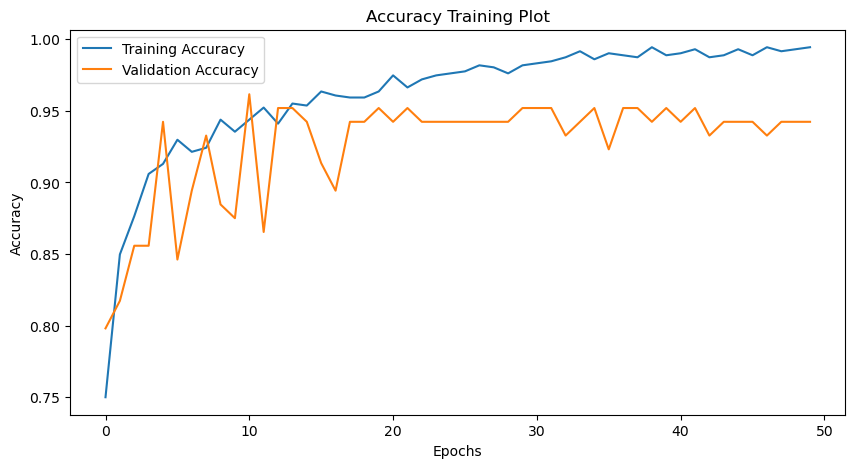

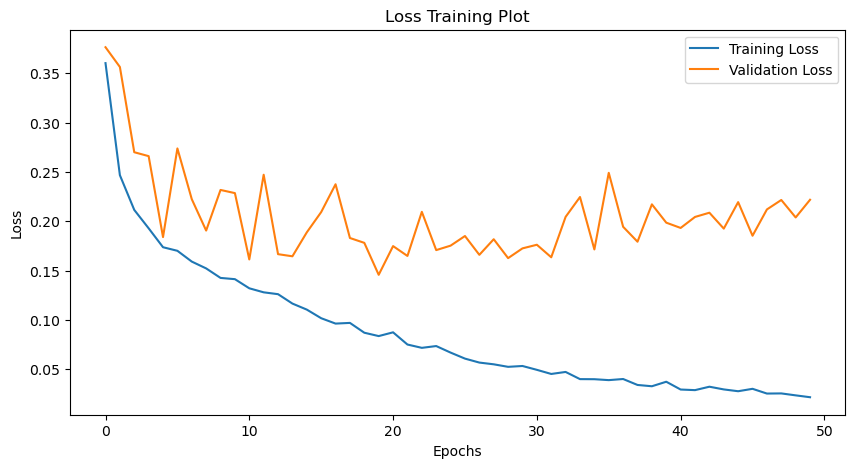

In [48]:
# Plot training graphs
plotAccuracy(history)
plotLoss(history)

In [49]:
printClassificationMetricsDualPath(dualPathModel, yTest, xTestStrong, xTestWeak, 0.50, "aveOralM")

7/7 [==============================] - 0s 2ms/step
aveOralM - Accuracy: 0.9653
aveOralM - Precision: 0.8000
aveOralM - Recall: 0.9091
aveOralM - ROC-AUC: 0.9407
aveOralM - MSE: 0.0347


In [50]:
printClassificationMetricsDualPath(dualPathModel, yTest, xTestStrong, xTestWeak, 0.50, "aveOralF")

7/7 [==============================] - 0s 2ms/step
aveOralF - Accuracy: 0.9653
aveOralF - Precision: 0.8000
aveOralF - Recall: 0.9091
aveOralF - ROC-AUC: 0.9407
aveOralF - MSE: 0.0347


Our training shows this is a good capacity for this network aproach and we get very good metrics for Precision, Recall and ROC-AUC. All of which beat the previous model at the same threshold and Recall and ROC-AUC is better even with higher threshold. This model approach has potential to be the most robust. We can now also apply regularisation to see how much further we can increase our metrics:

In [56]:
tf.keras.backend.clear_session()
inputStrong = Input(shape=(26,), name="strongFeatures")
inputWeak = Input(shape=(xTrain.shape[1] - 26,), name="weakFeatures")

strongPath = Dense(64, activation="relu", kernel_regularizer=l2(0.005))(inputStrong)
strongPath = Dropout(0.3)(strongPath)
strongPath = Dense(32, activation="relu", kernel_regularizer=l2(0.005))(strongPath)
strongPath = Dropout(0.3)(strongPath)

weakPath = Dense(32, activation="relu", kernel_regularizer=l2(0.003))(inputWeak)
weakPath = Dropout(0.2)(weakPath)
weakPath = Dense(16, activation="relu", kernel_regularizer=l2(0.003))(weakPath)
weakPath = Dropout(0.2)(weakPath)

merged = Concatenate()([strongPath, weakPath])
output = Dense(1, activation="sigmoid")(merged)

dualPathModelRemedy = Model(inputs=[inputStrong, inputWeak], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008, clipnorm=1.0)
dualPathModelRemedy.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = dualPathModelRemedy.fit(
    [xTrainStrong, xTrainWeak], yTrain,
    validation_data=([xValStrong, xValWeak], yVal),
    epochs=50,
    batch_size=16,
    class_weight=classWeights
)

Epoch 1/50
45/45 [==============================] - 1s 12ms/step - loss: 1.0511 - accuracy: 0.5211 - val_loss: 1.0258 - val_accuracy: 0.6923
Epoch 2/50
45/45 [==============================] - 0s 9ms/step - loss: 0.8376 - accuracy: 0.7598 - val_loss: 0.8545 - val_accuracy: 0.7788
Epoch 3/50
45/45 [==============================] - 0s 10ms/step - loss: 0.7433 - accuracy: 0.8272 - val_loss: 0.7709 - val_accuracy: 0.8077
Epoch 4/50
45/45 [==============================] - 0s 9ms/step - loss: 0.6724 - accuracy: 0.8244 - val_loss: 0.6798 - val_accuracy: 0.8365
Epoch 5/50
45/45 [==============================] - 0s 9ms/step - loss: 0.6227 - accuracy: 0.8399 - val_loss: 0.6344 - val_accuracy: 0.8558
Epoch 6/50
45/45 [==============================] - 0s 10ms/step - loss: 0.5768 - accuracy: 0.8694 - val_loss: 0.6010 - val_accuracy: 0.8558
Epoch 7/50
45/45 [==============================] - 0s 9ms/step - loss: 0.5394 - accuracy: 0.8778 - val_loss: 0.5844 - val_accuracy: 0.8558
Epoch 8/50
45/45 

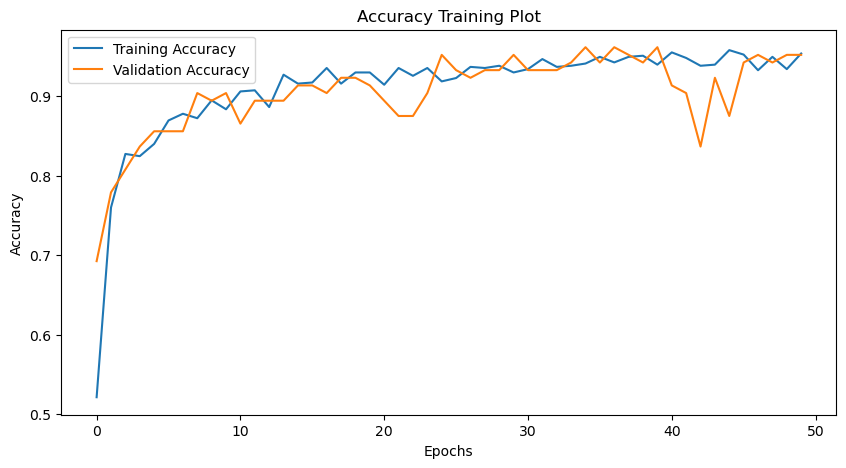

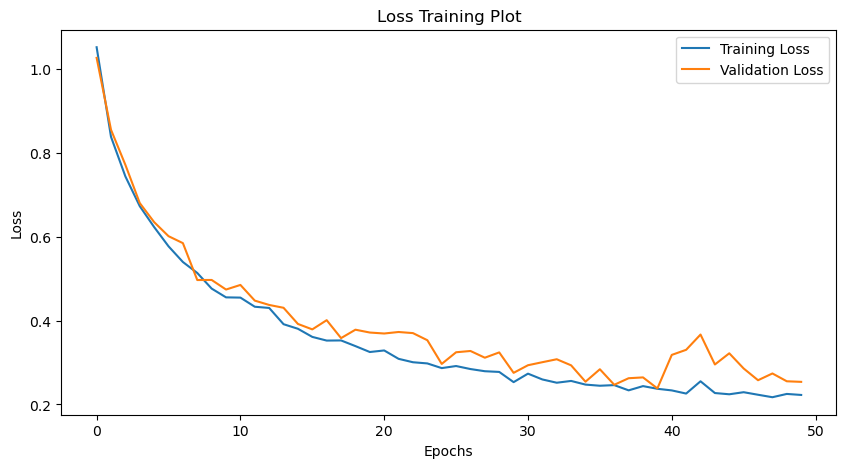

In [57]:
# Plot training graphs
plotAccuracy(history)
plotLoss(history)

In [61]:
printClassificationMetricsDualPath(dualPathModelRemedy, yTest, xTestStrong, xTestWeak, 0.50, "aveOralM")

7/7 [==============================] - 0s 1ms/step
aveOralM - Accuracy: 0.9653
aveOralM - Precision: 0.7778
aveOralM - Recall: 0.9545
aveOralM - ROC-AUC: 0.9606
aveOralM - MSE: 0.0347


In [59]:
printClassificationMetricsDualPath(dualPathModelRemedy, yTest, xTestStrong, xTestWeak, 0.90, "aveOralM")

7/7 [==============================] - 0s 1ms/step
aveOralM - Accuracy: 0.9653
aveOralM - Precision: 0.8947
aveOralM - Recall: 0.7727
aveOralM - ROC-AUC: 0.8808
aveOralM - MSE: 0.0347


In [60]:
printClassificationMetricsDualPath(dualPathModelRemedy, yTest, xTestStrong, xTestWeak, 0.90, "aveOralF")

7/7 [==============================] - 0s 2ms/step
aveOralF - Accuracy: 0.9653
aveOralF - Precision: 0.8947
aveOralF - Recall: 0.7727
aveOralF - ROC-AUC: 0.8808
aveOralF - MSE: 0.0347


Regularisation has remedied the overfitting and the metrics now compete better, in some cases, than the previous model. The Dual Path model has slightly better Recall and ROC-AUC but a reduced Precision of 5%. We can assume that both Single Path and Dual Path models predict effectively and perform similarly in their respective given setups at 50 Epochs.

We can fine-tune both models to find their optimal hyperparameters and therefore conclude which model performs the best and the greatest metrics they can achieve.

# 4.6) Fine-Tuning Single Path

---



In [75]:
yValues = yClassification["aveOralM_Binary"]

xTrain, xVal, yTrain, yVal = train_test_split(dfEncoded, yValues, test_size=0.3, stratify=yValues, shuffle=True, random_state=42)
xVal, xTest, yVal, yTest = train_test_split(xVal, yVal, test_size=0.66, stratify=yVal, shuffle=True, random_state=42)

scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xVal = scaler.transform(xVal)
xTest = scaler.transform(xTest) 

classWeights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(yTrain),
    y=yTrain)
classWeights = dict(enumerate(classWeights))

To automate the process, we will use Hyperband with Keras Tuner to gradually go through all appropriate permutations up until an early stopping point which will help us reduce compute time.

In [73]:
# Define our single path model for tuning
def singlePathModel(hp):
    model = Sequential()

    model.add(Dense(128, input_dim=xTrain.shape[1], activation="relu",
                    kernel_regularizer=l2(hp.Float("l2_regularizer_1", min_value=1e-6, max_value=1e-2, sampling="log"))))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.01, max_value=0.3, step=0.025)))
    
    model.add(Dense(64, activation="relu", 
                    kernel_regularizer=l2(hp.Float("l2_regularizer_2", min_value=1e-6, max_value=1e-2, sampling="log"))))
    model.add(Dropout(hp.Float("dropout_2", min_value=0.01, max_value=0.3, step=0.025)))
    
    model.add(Dense(1, activation="sigmoid"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Expand our search to do 100 epochs 
tuner = kt.Hyperband(
    singlePathModel,
    objective="val_accuracy",
    max_epochs=100,
    factor=3,
    directory=MODELS_DIR,
    project_name="singlePathModelTuning_aveOralM"
)

# Add early stopping to prevent wasting time on an overfitting length of Epochs
earlyStopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Perform the hyperparameter search
tuner.search(xTrain, yTrain, validation_data=(xVal, yVal), epochs=100, batch_size=16, class_weight=classWeights, callbacks=[earlyStopping])

# Get the best model and parameters
bestParams = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Dropout 1 Rate: {bestParams.get('dropout_1')}")
print(f"Best Dropout 2 Rate: {bestParams.get('dropout_2')}")
print(f"Best L2 Regularizer 1: {bestParams.get('l2_regularizer_1')}")
print(f"Best L2 Regularizer 2: {bestParams.get('l2_regularizer_2')}")

Trial 254 Complete [00h 00m 06s]
val_accuracy: 0.9038461446762085

Best val_accuracy So Far: 0.9711538553237915
Total elapsed time: 00h 12m 50s
Best Dropout 1 Rate: 0.085
Best Dropout 2 Rate: 0.035
Best L2 Regularizer 1: 1.506166969796555e-05
Best L2 Regularizer 2: 0.0001835995719271289


Use best params to find optimal epoch:

In [98]:
tf.keras.backend.clear_session()
tunedSinglePathModel = Sequential()
tunedSinglePathModel.add(Dense(128, input_dim=xTrain.shape[1], activation="relu", kernel_regularizer=l2(1.506166969796555e-05)))
tunedSinglePathModel.add(Dropout(0.085))
tunedSinglePathModel.add(Dense(64, activation="relu", kernel_regularizer=l2(0.0001835995719271289)))
tunedSinglePathModel.add(Dropout(0.035)) 
tunedSinglePathModel.add(Dense(1, activation="sigmoid"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
tunedSinglePathModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = tunedSinglePathModel.fit(xTrain, yTrain,
                    validation_data=(xVal, yVal),
                    epochs=50,
                    batch_size=16,
                    class_weight=classWeights)

Epoch 1/50
45/45 [==============================] - 1s 9ms/step - loss: 0.4075 - accuracy: 0.8104 - val_loss: 0.3764 - val_accuracy: 0.8077
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 0.2644 - accuracy: 0.8455 - val_loss: 0.3035 - val_accuracy: 0.8365
Epoch 3/50
45/45 [==============================] - 0s 7ms/step - loss: 0.2471 - accuracy: 0.8736 - val_loss: 0.2614 - val_accuracy: 0.8654
Epoch 4/50
45/45 [==============================] - 0s 7ms/step - loss: 0.2287 - accuracy: 0.9031 - val_loss: 0.2297 - val_accuracy: 0.8846
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 0.2167 - accuracy: 0.8947 - val_loss: 0.2541 - val_accuracy: 0.8846
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 0.2020 - accuracy: 0.9185 - val_loss: 0.1986 - val_accuracy: 0.9231
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 0.1895 - accuracy: 0.9087 - val_loss: 0.1986 - val_accuracy: 0.9135
Epoch 8/50
45/45 [==

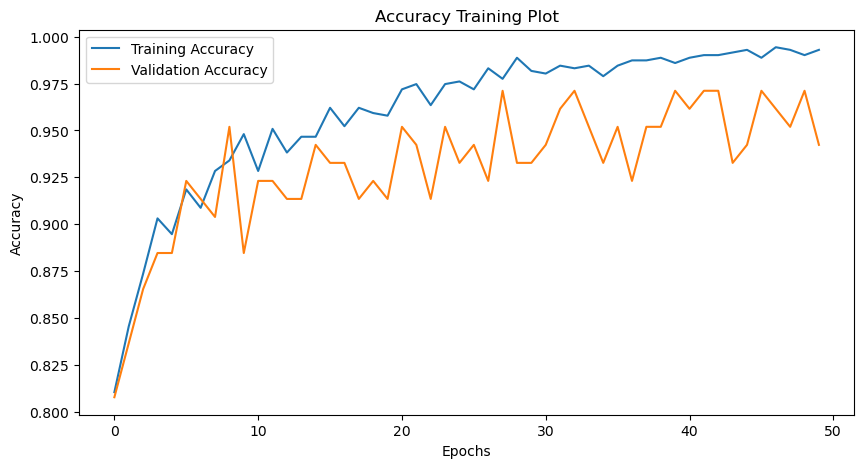

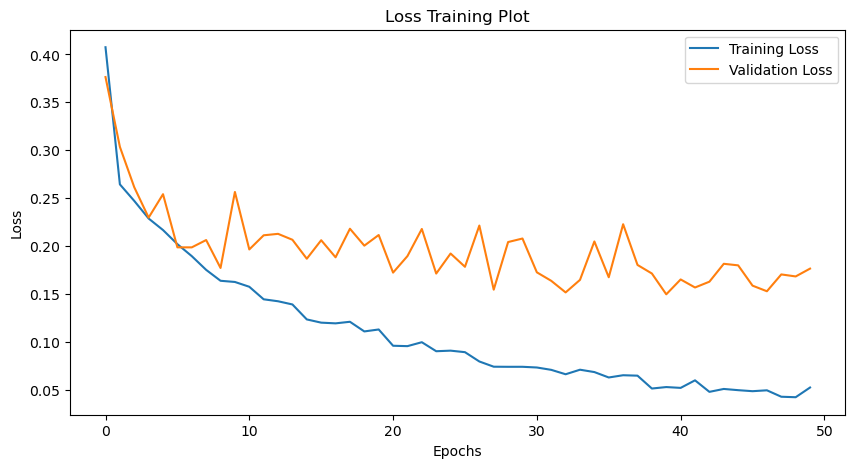

In [99]:
plotAccuracy(history)
plotLoss(history)

Complete retrain at optimal Epoch of 47:

In [100]:
# Use all of training dataset, therefore no more validation set
xTrain = np.concatenate((xTrain, xVal))
yTrain = np.concatenate((yTrain, yVal))

tf.keras.backend.clear_session()
tunedSinglePathModel = Sequential()
tunedSinglePathModel.add(Dense(128, input_dim=xTrain.shape[1], activation="relu", kernel_regularizer=l2(1.506166969796555e-05)))
tunedSinglePathModel.add(Dropout(0.085))
tunedSinglePathModel.add(Dense(64, activation="relu", kernel_regularizer=l2(0.0001835995719271289)))
tunedSinglePathModel.add(Dropout(0.035)) 
tunedSinglePathModel.add(Dense(1, activation="sigmoid"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
tunedSinglePathModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = tunedSinglePathModel.fit(xTrain, yTrain,
                    epochs=47,
                    batch_size=16,
                    class_weight=classWeights)

Epoch 1/47
51/51 [==============================] - 1s 5ms/step - loss: 0.4582 - accuracy: 0.6091
Epoch 2/47
51/51 [==============================] - 0s 5ms/step - loss: 0.2785 - accuracy: 0.8419
Epoch 3/47
51/51 [==============================] - 0s 5ms/step - loss: 0.2437 - accuracy: 0.8934
Epoch 4/47
51/51 [==============================] - 0s 5ms/step - loss: 0.2266 - accuracy: 0.9020
Epoch 5/47
51/51 [==============================] - 0s 5ms/step - loss: 0.2063 - accuracy: 0.9240
Epoch 6/47
51/51 [==============================] - 0s 5ms/step - loss: 0.1996 - accuracy: 0.9228
Epoch 7/47
51/51 [==============================] - 0s 5ms/step - loss: 0.1913 - accuracy: 0.9240
Epoch 8/47
51/51 [==============================] - 0s 5ms/step - loss: 0.1756 - accuracy: 0.9326
Epoch 9/47
51/51 [==============================] - 0s 5ms/step - loss: 0.1595 - accuracy: 0.9350
Epoch 10/47
51/51 [==============================] - 0s 5ms/step - loss: 0.1697 - accuracy: 0.9412
Epoch 11/47
51/51 [

In [101]:
printClassificationMetrics(tunedSinglePathModel, yTest, xTest, 0.90, "aveOralM")
printClassificationMetrics(tunedSinglePathModel, yTest, xTest, 0.90, "aveOralF")

7/7 [==============================] - 0s 1ms/step
aveOralM - Accuracy: 0.9604
aveOralM - Precision: 0.8182
aveOralM - Recall: 0.8182
aveOralM - ROC-AUC: 0.8980
aveOralM - MSE: 0.0396
7/7 [==============================] - 0s 1ms/step
aveOralF - Accuracy: 0.9604
aveOralF - Precision: 0.8182
aveOralF - Recall: 0.8182
aveOralF - ROC-AUC: 0.8980
aveOralF - MSE: 0.0396


Single Path (aveOralM) aveOralM Metrics:

`aveOralM - Accuracy: 0.9604`

`aveOralM - Precision: 0.8182`

`aveOralM - Recall: 0.8182`

`aveOralM - ROC-AUC: 0.8980`

`aveOralM - MSE: 0.0396`


Single Path (aveOralM) aveOralF Metrics:

`aveOralF - Accuracy: 0.9604`

`aveOralF - Precision: 0.8182`

`aveOralF - Recall: 0.8182`

`aveOralF - ROC-AUC: 0.8980`

`aveOralF - MSE: 0.0396`

Although previously stated we suggested that using the model findings from aveOralM would suffice for Fast-mode, we can try and find the best parameters for Fast-mode and compare the final results to see the difference in performance.

In [74]:
yValues = yClassification["aveOralF_Binary"]
xTrain, xVal, yTrain, yVal = train_test_split(dfEncoded, yValues, test_size=0.3, stratify=yValues, shuffle=True, random_state=42)
xVal, xTest, yVal, yTest = train_test_split(xVal, yVal, test_size=0.66, stratify=yVal, shuffle=True, random_state=42)
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xVal = scaler.transform(xVal)
xTest = scaler.transform(xTest) 

tuner = kt.Hyperband(
    singlePathModel,
    objective="val_accuracy",
    max_epochs=100,
    factor=3,
    directory=MODELS_DIR,
    project_name="singlePathModelTuning_aveOralF"
)

earlyStopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


tuner.search(xTrain, yTrain, validation_data=(xVal, yVal), epochs=100, batch_size=16, class_weight=classWeights, callbacks=[earlyStopping])
bestParams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Dropout 1 Rate: {bestParams.get('dropout_1')}")
print(f"Best Dropout 2 Rate: {bestParams.get('dropout_2')}")
print(f"Best L2 Regularizer 1: {bestParams.get('l2_regularizer_1')}")
print(f"Best L2 Regularizer 2: {bestParams.get('l2_regularizer_2')}")

Trial 254 Complete [00h 00m 07s]
val_accuracy: 0.942307710647583

Best val_accuracy So Far: 0.9711538553237915
Total elapsed time: 00h 12m 42s
Best Dropout 1 Rate: 0.23500000000000001
Best Dropout 2 Rate: 0.035
Best L2 Regularizer 1: 0.009542249505884493
Best L2 Regularizer 2: 0.00011803356902493938


In [84]:
tf.keras.backend.clear_session()
tunedSinglePathModel = Sequential()
tunedSinglePathModel.add(Dense(128, input_dim=xTrain.shape[1], activation="relu", kernel_regularizer=l2(0.009542249505884493)))
tunedSinglePathModel.add(Dropout(0.23500000000000001))
tunedSinglePathModel.add(Dense(64, activation="relu", kernel_regularizer=l2(0.00011803356902493938)))
tunedSinglePathModel.add(Dropout(0.035)) 
tunedSinglePathModel.add(Dense(1, activation="sigmoid"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
tunedSinglePathModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = tunedSinglePathModel.fit(xTrain, yTrain,
                    validation_data=(xVal, yVal),
                    epochs=50,
                    batch_size=16,
                    class_weight=classWeights)

Epoch 1/50
45/45 [==============================] - 1s 10ms/step - loss: 1.0945 - accuracy: 0.8652 - val_loss: 0.9466 - val_accuracy: 0.8654
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 0.7586 - accuracy: 0.8947 - val_loss: 0.7605 - val_accuracy: 0.9038
Epoch 3/50
45/45 [==============================] - 0s 8ms/step - loss: 0.6566 - accuracy: 0.9340 - val_loss: 0.7151 - val_accuracy: 0.9038
Epoch 4/50
45/45 [==============================] - 0s 7ms/step - loss: 0.5826 - accuracy: 0.9508 - val_loss: 0.6883 - val_accuracy: 0.8846
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 0.5523 - accuracy: 0.9537 - val_loss: 0.5456 - val_accuracy: 0.9423
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4853 - accuracy: 0.9522 - val_loss: 0.5093 - val_accuracy: 0.9327
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4780 - accuracy: 0.9593 - val_loss: 0.5025 - val_accuracy: 0.9327
Epoch 8/50
45/45 [=

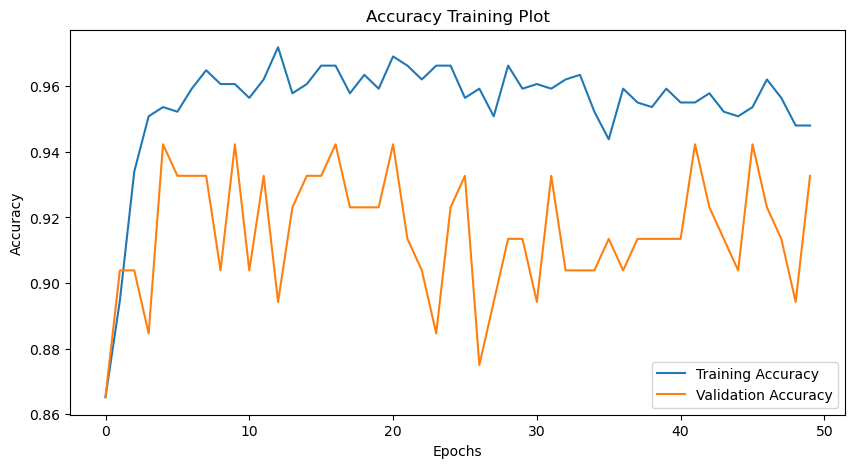

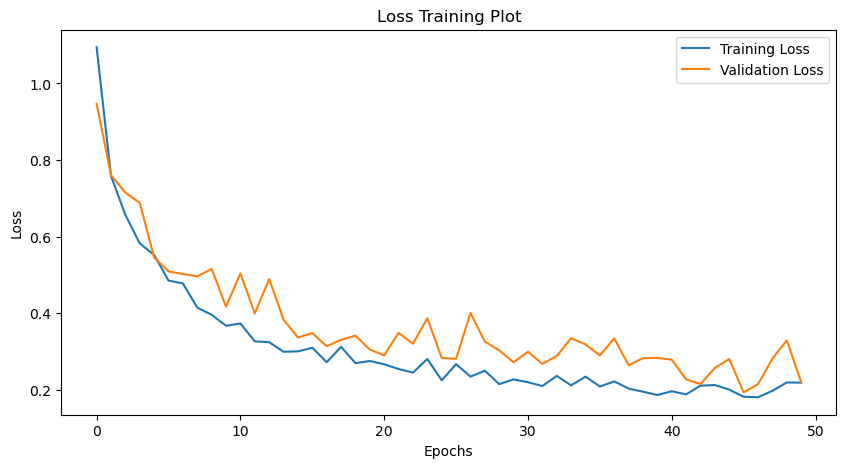

In [85]:
plotAccuracy(history)
plotLoss(history)

At optimal epoch of 46:

In [88]:
xTrain = np.concatenate((xTrain, xVal))
yTrain = np.concatenate((yTrain, yVal))

tf.keras.backend.clear_session()
tunedSinglePathModel = Sequential()
tunedSinglePathModel.add(Dense(128, input_dim=xTrain.shape[1], activation="relu", kernel_regularizer=l2(0.009542249505884493)))
tunedSinglePathModel.add(Dropout(0.23500000000000001))
tunedSinglePathModel.add(Dense(64, activation="relu", kernel_regularizer=l2(0.00011803356902493938)))
tunedSinglePathModel.add(Dropout(0.035)) 
tunedSinglePathModel.add(Dense(1, activation="sigmoid"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
tunedSinglePathModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = tunedSinglePathModel.fit(xTrain, yTrain,
                    epochs=46,
                    batch_size=16,
                    class_weight=classWeights)

Epoch 1/46
58/58 [==============================] - 1s 6ms/step - loss: 0.9789 - accuracy: 0.8870
Epoch 2/46
58/58 [==============================] - 0s 6ms/step - loss: 0.7002 - accuracy: 0.9054
Epoch 3/46
58/58 [==============================] - 0s 6ms/step - loss: 0.5892 - accuracy: 0.9467
Epoch 4/46
58/58 [==============================] - 0s 6ms/step - loss: 0.5172 - accuracy: 0.9446
Epoch 5/46
58/58 [==============================] - 0s 6ms/step - loss: 0.4508 - accuracy: 0.9565
Epoch 6/46
58/58 [==============================] - 0s 6ms/step - loss: 0.4378 - accuracy: 0.9598
Epoch 7/46
58/58 [==============================] - 0s 6ms/step - loss: 0.4194 - accuracy: 0.9467
Epoch 8/46
58/58 [==============================] - 0s 6ms/step - loss: 0.3876 - accuracy: 0.9620
Epoch 9/46
58/58 [==============================] - 0s 6ms/step - loss: 0.3662 - accuracy: 0.9522
Epoch 10/46
58/58 [==============================] - 0s 6ms/step - loss: 0.3347 - accuracy: 0.9554
Epoch 11/46
58/58 [

In [89]:
printClassificationMetrics(tunedSinglePathModel, yTest, xTest, 0.90, "aveOralF")

7/7 [==============================] - 0s 1ms/step
aveOralF - Accuracy: 0.9653
aveOralF - Precision: 0.8750
aveOralF - Recall: 0.5385
aveOralF - ROC-AUC: 0.7666
aveOralF - MSE: 0.0347


Single Path aveOralF Metrics:

`aveOralF - Accuracy: 0.9653`

`aveOralF - Precision: 0.8750`

`aveOralF - Recall: 0.5385`

`aveOralF - ROC-AUC: 0.7666`

`aveOralF - MSE: 0.0347`

# 4.7) Fine-Tuning Dual Path

---


In [106]:
yValues = yClassification["aveOralM_Binary"]
xTrain, xVal, yTrain, yVal = train_test_split(dfDual, yValues, test_size=0.3, stratify=yValues, shuffle=True, random_state=42)
xVal, xTest, yVal, yTest = train_test_split(xVal, yVal, test_size=0.66, stratify=yVal, shuffle=True, random_state=42)

scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xVal = scaler.transform(xVal)
xTest = scaler.transform(xTest) 

xTrainStrong = xTrain[:, :26]
xTrainWeak = xTrain[:, 26:]
xValStrong = xVal[:, :26]
xValWeak = xVal[:, 26:]
xTestStrong = xTest[:, :26]
xTestWeak = xTest[:, 26:]

classWeights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(yTrain),
    y=yTrain)
classWeights = dict(enumerate(classWeights))

In [95]:
# Define our dual path model for tuning
def dualPathModel(hp):
    inputStrong = Input(shape=(26,), name="strongFeatures")
    inputWeak = Input(shape=(xTrain.shape[1] - 26,), name="weakFeatures")

    strongPath = Dense(64, activation="relu", kernel_regularizer=l2(hp.Float("l2_regularizer_1", min_value=1e-6, max_value=1e-2, sampling="log")))(inputStrong)
    strongPath = Dropout(hp.Float("dropout_1", min_value=0.01, max_value=0.3, step=0.025))(strongPath)
    strongPath = Dense(32, activation="relu", kernel_regularizer=l2(hp.Float("l2_regularizer_2", min_value=1e-6, max_value=1e-2, sampling="log")))(strongPath)
    strongPath = Dropout(hp.Float("dropout_2", min_value=0.01, max_value=0.3, step=0.025))(strongPath)
    
    weakPath = Dense(32, activation="relu", kernel_regularizer=l2(hp.Float("l2_regularizer_3", min_value=1e-6, max_value=1e-2, sampling="log")))(inputWeak)
    weakPath = Dropout(hp.Float("dropout_3", min_value=0.01, max_value=0.3, step=0.025))(weakPath)
    weakPath = Dense(16, activation="relu", kernel_regularizer=l2(hp.Float("l2_regularizer_4", min_value=1e-6, max_value=1e-2, sampling="log")))(weakPath)
    weakPath = Dropout(hp.Float("dropout_4", min_value=0.01, max_value=0.3, step=0.025))(weakPath)

    merged = Concatenate()([strongPath, weakPath])
    output = Dense(1, activation="sigmoid")(merged)

    model = Model(inputs=[inputStrong, inputWeak], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Setup the tuner with Hyperband
tuner = kt.Hyperband(
    dualPathModel, 
    objective="val_accuracy",
    max_epochs=100, 
    factor=3, 
    directory=MODELS_DIR, 
    project_name="dualPathModelTuning_aveOralM"
)

earlyStopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

tuner.search([xTrainStrong, xTrainWeak], yTrain, validation_data=([xValStrong, xValWeak], yVal), epochs=100, batch_size=16, class_weight=classWeights, callbacks=[earlyStopping])

bestParams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Dropout 1 Rate: {bestParams.get('dropout_1')}")
print(f"Best Dropout 2 Rate: {bestParams.get('dropout_2')}")
print(f"Best Dropout 3 Rate: {bestParams.get('dropout_3')}")
print(f"Best Dropout 4 Rate: {bestParams.get('dropout_4')}")
print(f"Best L2 Regularizer 1: {bestParams.get('l2_regularizer_1')}")
print(f"Best L2 Regularizer 2: {bestParams.get('l2_regularizer_2')}")
print(f"Best L2 Regularizer 3: {bestParams.get('l2_regularizer_3')}")
print(f"Best L2 Regularizer 4: {bestParams.get('l2_regularizer_4')}")

Trial 254 Complete [00h 00m 22s]
val_accuracy: 0.9519230723381042

Best val_accuracy So Far: 0.9711538553237915
Total elapsed time: 00h 17m 55s
Best Dropout 1 Rate: 0.11
Best Dropout 2 Rate: 0.060000000000000005
Best Dropout 3 Rate: 0.060000000000000005
Best Dropout 4 Rate: 0.23500000000000001
Best L2 Regularizer 1: 0.0027081896556546328
Best L2 Regularizer 2: 0.0014453012630347246
Best L2 Regularizer 3: 0.00010785584236754019
Best L2 Regularizer 4: 1.588814157663961e-06


In [103]:
tf.keras.backend.clear_session()
inputStrong = Input(shape=(26,), name="strongFeatures")
inputWeak = Input(shape=(xTrain.shape[1] - 26,), name="weakFeatures")

strongPath = Dense(64, activation="relu", kernel_regularizer=l2(0.0027081896556546328))(inputStrong)
strongPath = Dropout(0.11)(strongPath)
strongPath = Dense(32, activation="relu", kernel_regularizer=l2(0.0014453012630347246))(strongPath)
strongPath = Dropout(0.060000000000000005)(strongPath)

weakPath = Dense(32, activation="relu", kernel_regularizer=l2(0.00010785584236754019))(inputWeak)
weakPath = Dropout(0.060000000000000005)(weakPath)
weakPath = Dense(16, activation="relu", kernel_regularizer=l2(1.588814157663961e-06))(weakPath)
weakPath = Dropout(0.23500000000000001)(weakPath)

merged = Concatenate()([strongPath, weakPath])
output = Dense(1, activation="sigmoid")(merged)

tunedDualPathModel = Model(inputs=[inputStrong, inputWeak], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008, clipnorm=1.0)
tunedDualPathModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = tunedDualPathModel.fit(
    [xTrainStrong, xTrainWeak], yTrain,
    validation_data=([xValStrong, xValWeak], yVal),
    epochs=50,
    batch_size=16,
    class_weight=classWeights
)

Epoch 1/50
45/45 [==============================] - 1s 12ms/step - loss: 0.5997 - accuracy: 0.7879 - val_loss: 0.5812 - val_accuracy: 0.7500
Epoch 2/50
45/45 [==============================] - 0s 9ms/step - loss: 0.4410 - accuracy: 0.7879 - val_loss: 0.4906 - val_accuracy: 0.7788
Epoch 3/50
45/45 [==============================] - 0s 9ms/step - loss: 0.3887 - accuracy: 0.8455 - val_loss: 0.4209 - val_accuracy: 0.8750
Epoch 4/50
45/45 [==============================] - 0s 10ms/step - loss: 0.3611 - accuracy: 0.8848 - val_loss: 0.4247 - val_accuracy: 0.8750
Epoch 5/50
45/45 [==============================] - 0s 9ms/step - loss: 0.3457 - accuracy: 0.8764 - val_loss: 0.3496 - val_accuracy: 0.8942
Epoch 6/50
45/45 [==============================] - 0s 10ms/step - loss: 0.3228 - accuracy: 0.9143 - val_loss: 0.3848 - val_accuracy: 0.8750
Epoch 7/50
45/45 [==============================] - 0s 9ms/step - loss: 0.3165 - accuracy: 0.8947 - val_loss: 0.3314 - val_accuracy: 0.8942
Epoch 8/50
45/45 

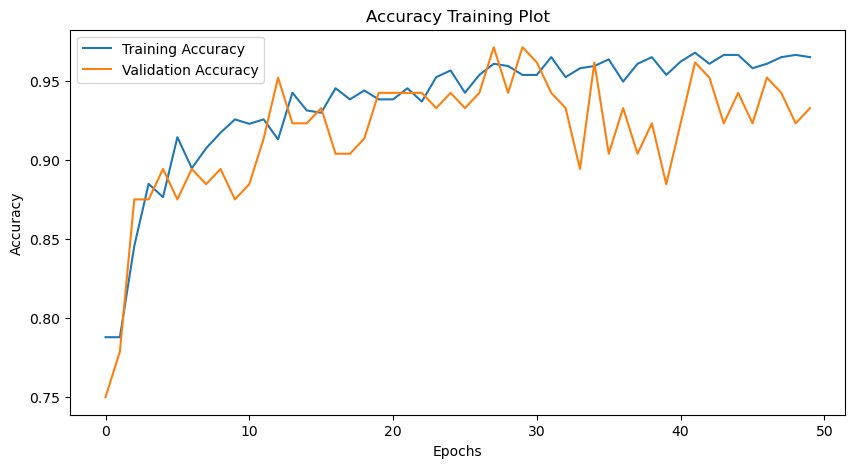

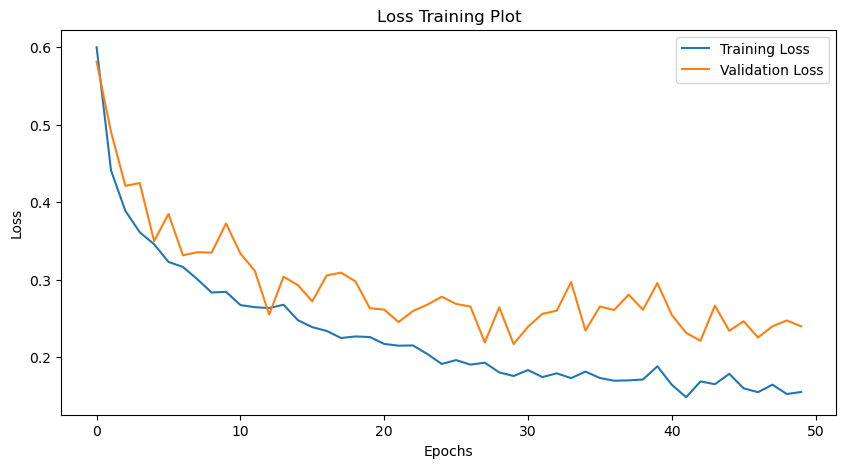

In [104]:
# Plot training graphs
plotAccuracy(history)
plotLoss(history)

Retrain at optimal Epoch of 30:

In [108]:
tf.keras.backend.clear_session()
inputStrong = Input(shape=(26,), name="strongFeatures")
inputWeak = Input(shape=(xTrain.shape[1] - 26,), name="weakFeatures")

strongPath = Dense(64, activation="relu", kernel_regularizer=l2(0.0027081896556546328))(inputStrong)
strongPath = Dropout(0.11)(strongPath)
strongPath = Dense(32, activation="relu", kernel_regularizer=l2(0.0014453012630347246))(strongPath)
strongPath = Dropout(0.060000000000000005)(strongPath)

weakPath = Dense(32, activation="relu", kernel_regularizer=l2(0.00010785584236754019))(inputWeak)
weakPath = Dropout(0.060000000000000005)(weakPath)
weakPath = Dense(16, activation="relu", kernel_regularizer=l2(1.588814157663961e-06))(weakPath)
weakPath = Dropout(0.23500000000000001)(weakPath)

merged = Concatenate()([strongPath, weakPath])
output = Dense(1, activation="sigmoid")(merged)

tunedDualPathModel = Model(inputs=[inputStrong, inputWeak], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008, clipnorm=1.0)
tunedDualPathModel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

xTrainStrongFull = np.concatenate([xTrainStrong, xValStrong], axis=0)
xTrainWeakFull = np.concatenate([xTrainWeak, xValWeak], axis=0)
yTrainFull = np.concatenate([yTrain, yVal], axis=0)

history = tunedDualPathModel.fit(
    [xTrainStrongFull, xTrainWeakFull], yTrainFull,
    epochs=30,
    batch_size=16,
    class_weight=classWeights
)

Epoch 1/30
51/51 [==============================] - 1s 8ms/step - loss: 0.6769 - accuracy: 0.6507
Epoch 2/30
51/51 [==============================] - 0s 8ms/step - loss: 0.4791 - accuracy: 0.7439
Epoch 3/30
51/51 [==============================] - 0s 8ms/step - loss: 0.4027 - accuracy: 0.8174
Epoch 4/30
51/51 [==============================] - 0s 8ms/step - loss: 0.3858 - accuracy: 0.8591
Epoch 5/30
51/51 [==============================] - 0s 8ms/step - loss: 0.3637 - accuracy: 0.8725
Epoch 6/30
51/51 [==============================] - 0s 8ms/step - loss: 0.3345 - accuracy: 0.8897
Epoch 7/30
51/51 [==============================] - 0s 8ms/step - loss: 0.3256 - accuracy: 0.8958
Epoch 8/30
51/51 [==============================] - 0s 8ms/step - loss: 0.3098 - accuracy: 0.9142
Epoch 9/30
51/51 [==============================] - 0s 8ms/step - loss: 0.3011 - accuracy: 0.8922
Epoch 10/30
51/51 [==============================] - 0s 8ms/step - loss: 0.2978 - accuracy: 0.9044
Epoch 11/30
51/51 [

In [116]:
printClassificationMetricsDualPath(tunedDualPathModel, yTest, xTestStrong, xTestWeak, 0.95, "aveOralM")
printClassificationMetricsDualPath(tunedDualPathModel, yTest, xTestStrong, xTestWeak, 0.95, "aveOralF")

7/7 [==============================] - 0s 2ms/step
aveOralM - Accuracy: 0.9554
aveOralM - Precision: 0.8824
aveOralM - Recall: 0.6818
aveOralM - ROC-AUC: 0.8354
aveOralM - MSE: 0.0446
7/7 [==============================] - 0s 1ms/step
aveOralF - Accuracy: 0.9554
aveOralF - Precision: 0.8824
aveOralF - Recall: 0.6818
aveOralF - ROC-AUC: 0.8354
aveOralF - MSE: 0.0446


Slightly higher threshold hurts our metrics, therefore we will need to use the 90% threshold for the final metrics which have not improved at the same threshold after the tuning:

Dual Path (aveOralM) aveOralM Metrics:

`aveOralM - Accuracy: 0.9653`

`aveOralM - Precision: 0.8947`

`aveOralM - Recall: 0.7727`

`aveOralM - ROC-AUC: 0.8808`

`aveOralM - MSE: 0.0347`


Dual Path (aveOralM) aveOralF Metrics:

`aveOralF - Accuracy: 0.9653`

`aveOralF - Precision: 0.8947`

`aveOralF - Recall: 0.7727`

`aveOralF - ROC-AUC: 0.8808`

`aveOralF - MSE: 0.0347`

# 4.8) Findings of Tuned Neural Models

---



Now that we've compared a few models, isolated to 2 models and tuned them to both targets, we can conclude our findings and best metrics.

Here are the final list of metrics, both targets perform the same using the same model setup and thresholds (90%):

Single Path (aveOralM) aveOralM Metrics:

`aveOralM - Accuracy: 0.9604`

`aveOralM - Precision: 0.8182`

`aveOralM - Recall: 0.8182`

`aveOralM - ROC-AUC: 0.8980`

`aveOralM - MSE: 0.0396`


Single Path (aveOralM) aveOralF Metrics:

`aveOralF - Accuracy: 0.9604`

`aveOralF - Precision: 0.8182`

`aveOralF - Recall: 0.8182`

`aveOralF - ROC-AUC: 0.8980`

`aveOralF - MSE: 0.0396`


Dual Path (aveOralM) aveOralM Metrics:

`aveOralM - Accuracy: 0.9653`

`aveOralM - Precision: 0.8947`

`aveOralM - Recall: 0.7727`

`aveOralM - ROC-AUC: 0.8808`

`aveOralM - MSE: 0.0347`


Dual Path (aveOralM) aveOralF Metrics:

`aveOralF - Accuracy: 0.9653`

`aveOralF - Precision: 0.8947`

`aveOralF - Recall: 0.7727`

`aveOralF - ROC-AUC: 0.8808`

`aveOralF - MSE: 0.0347`

These results tell us that Dual Path is the best for MSE, we get a difference of around 0.0050, regardless both MSE metrics surpass all regression models. Additonally we have both statistical power over random guessing and the tuned models beat Logistic Regression in the respective targets.

The results also show that for reduced false positive rates, Dual Path is the better model, it scores a 0.0765 improvement over Single Path and brings it to almost 90% overall.

Single Path is better for ROC-AUC and Recall, where the difference is 0.0172 and 0.0455 respectively. 

We can see that the deltas between both models are not drastic but they illustrate the preferences each model have to the Precision-Recall balance.

Explanations as to why the metrics may not be higher may come down to the sample size, i.e, not a large enough dataset to learn effectively enough from, targets are very close in values especially when inspecting continuous targets therefore the model may have some difficulty given the smaller dataset.

With that being said, the best model is the Dual Path model. It overall has a higher Accuracy and the higher Precision benefits to our classification as we want to be precise and not claim false positives.

# **CONCLUSION**

---


To conclude this research, we investigated feature importances, their correlations, we established baslines in neural and regressive fashions. We investigated several different approaches to classifying the discrete and continuous targets. Insights were brought into light to show that both targets, although obtained via different methods, adhere to the same features and model setup's to produce similar if not the same metrics consistently.

Regression models were explored, comparing different regularisation techniques and algorithms to find which permutations maximised metrics of each respective continous targets.

Neural models were investigated and the effects of weak features, overfitting and different approaches to handling both led the research to find a Dual Path model which produces persuasive metrics, beating all other models explored.

To summarise we came to the conclusion that for Regression: KNN, ElasticNet performed the best for (Fast-mode, Monitor-mode respectively) - and for Classification: Dual Path Network performed the best for both targets.